## Скачаем датасет, использовавшийся для тренировки предыдущих моделей и выберем финальную модель

In [ ]:
!pip install -q optuna catboost

import numpy as np
import seaborn as sns

import pandas as pd
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

from matplotlib import pyplot as plt

import optuna

import itertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.9 MB/s eta 0:00:00


Скачаем маленькую и большую выборки (порядка 6513 и 13627 школ соответственно)

In [ ]:
small_data = pd.read_csv('preprocessed_small.csv', index_col=0)
small_data

class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn locality_type      population  correction  pupils_amount     district    target
login                                                                                                                                                                        
sch01110006_4_rus       4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648          НПСТ         0-1.000           0            141          ЮФО  0.643725
sch01110012_4_rus       4     rus  0.597039  0.441729  0.466374  0.714035 -0.130665  0.272306          НПСТ         0-1.000           0            140          ЮФО  0.616228
sch01110019_4_rus       4     rus  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705          НПСТ    1.000-10.000           0            251          ЮФО  0.653110
sch01110024_4_rus       4     rus  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514          НПСТ  10.000-100.000           0            896          ЮФО  0.731955
sch01110031_4_rus       4     rus  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540          НПСТ    1.000-10.000           0            162          ЮФО  0.673375
...                   ...     ...       ...       ...       ...       ...       ...       ...           ...             ...         ...            ...          ...       ...
sch92120045_6_math      6    math  0.741045  0.556349  0.607576  0.565254 -0.133469  0.008905         Город        100.000+           0            772  Севастополь  0.422414
sch92120052_6_math      6    math  0.621429  0.522727  0.529545  0.346000 -0.091883 -0.176727          НПСТ    1.000-10.000           0            295  Севастополь  0.358333
sch92120059_6_math      6    math  0.470000  0.308621  0.495833  0.286000  0.025833 -0.022621          НПСТ    1.000-10.000           0            315  Севастополь  0.220690
sch92122004_6_math      6    math  0.680769  0.628571  0.562500  0.511111 -0.118269 -0.117460         Город        100.000+           0            114  Севастополь  0.288889
sch92126001_6_math      6    math  0.703289  0.605128  0.587736  0.553731 -0.115554 -0.051397         Город        100.000+           0           1085  Севастополь  0.491667

[38376 rows x 14 columns]

In [ ]:
large_data = pd.read_csv('preprocessed_large.csv', index_col=0)
large_data

class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn locality_type      population  correction  pupils_amount district    target
login                                                                                                                                                                    
sch01110001_4_rus       4     rus  0.708502  0.650239  0.609133  0.665038 -0.099369  0.014798          НПСТ  10.000-100.000           0            611      ЮФО  0.707350
sch01110003_4_rus       4     rus  0.667825  0.690283  0.564662  0.689693 -0.103164 -0.000590          НПСТ    1.000-10.000           0            419      ЮФО  0.663158
sch01110004_4_rus       4     rus  0.593117  0.675252  0.508907  0.610871 -0.084211 -0.064381          НПСТ  10.000-100.000           0            612      ЮФО  0.714703
sch01110005_4_rus       4     rus  0.663743  0.812500  0.563910  0.657895 -0.099833 -0.154605          НПСТ    1.000-10.000           0            153      ЮФО  0.650376
sch01110006_4_rus       4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648          НПСТ         0-1.000           0            141      ЮФО  0.643725
...                   ...     ...       ...       ...       ...       ...       ...       ...           ...             ...         ...            ...      ...       ...
sch31110195_6_math      6    math  0.684694  0.523636  0.597674  0.378409 -0.087019 -0.145227         Город    1.000-10.000           0            582      ЦФО  0.463043
sch31110197_6_math      6    math  0.665000  0.553947  0.635714  0.581667 -0.029286  0.027719         Город    1.000-10.000           0            407      ЦФО  0.588333
sch31110201_6_math      6    math  0.495833  0.638462  0.571429  0.465000  0.075595 -0.173462          НПСТ    1.000-10.000           0            106      ЦФО  0.330000
sch31110202_6_math      6    math  0.669718  0.535455  0.461798  0.430328 -0.207921 -0.105127          НПГТ    1.000-10.000           0            703      ЦФО  0.503125
sch31110203_6_math      6    math  0.483333  0.563889  0.446154  0.600000 -0.037179  0.036111          НПГТ    1.000-10.000           0            150      ЦФО  0.518750

[69917 rows x 14 columns]

Для дальнейшего обучения была выбрана модель градиентного бустинга по следущим причинам:

1) В экспериментах она показала наилучшие результаты среди всех остальных моделей

2) Во время процедуры байесовской оптимизации набор из 20 моделей суммарно обучался не больше, чем 40 секунд, что крайне быстро (пусть и медленнее, чем опробованные случайный лес, метод ближайшего соседа и линейная регрессия с регуляризацией)

3) Для градиентного бустинга возможен анализ важности переменных. Таким образом можно понять, какой признак вносит какой вклад в предсказание модели

4) Реализация catboost не требует кодирования категориальных переменных

## Предобработка датасета

Напишем функцию, которая разделяет датасет на тренировочную, валидационную и тестовую выборки

Единственное, что предварительно стоит сделать, так это закодировать колонку population label-encoding-ом, чтобы большей численности населения соответствовало большее число

In [ ]:
begin_clusters = pd.read_csv('first_clustered_success.csv', index_col=0)[['cluster']]
begin_clusters.index.name = 'login'
begin_clusters

cluster
login               
sch05153598        2
sch05153203        2
sch05153051        3
sch05153436        2
sch05156212        3
...              ...
sch66166047        4
sch78183475        4
sch31116084        4
sch52123367        4
sch27173299        4

[6389 rows x 1 columns]

Выделим категориальные колонки в таблице

In [ ]:
categorical_columns = list(small_data.dtypes[small_data.dtypes == 'object'].index)
categorical_columns

['subject', 'locality_type', 'population', 'district']

Оставим во вспомогательной таблице только те колонки, которые однозначно помогут идентифицировать какую-то конкретную школу

In [ ]:
aux_data = small_data.drop(columns=['class', 'subject', 'target', '2019_4', '2019_5', '2020_5', '2020_6', '4_dyn', '5_dyn'])
aux_data.index = small_data.reset_index()['login'].apply(lambda x: x[:11])
aux_data = aux_data.reset_index().drop_duplicates().set_index('login')
aux_data

locality_type      population  correction  pupils_amount district
login                                                                               
sch01110006                 НПСТ         0-1.000           0            141      ЮФО
sch01110012                 НПСТ         0-1.000           0            140      ЮФО
sch01110019                 НПСТ    1.000-10.000           0            251      ЮФО
sch01110024                 НПСТ  10.000-100.000           0            896      ЮФО
sch01110031                 НПСТ    1.000-10.000           0            162      ЮФО
...                          ...             ...         ...            ...      ...
sch74146073                 НПСТ         0-1.000           0             66     УрФО
sch75153031                Город         0-1.000           0             96      СФО
sch77179462  Столица субъекта РФ        100.000+           0            387      ЦФО
sch86163002                 НПСТ         0-1.000           0             14     УрФО
sch11116052                 НПСТ         0-1.000           0             13     СЗФО

[6513 rows x 5 columns]

Подправим Севастополь, как и в предыдущем ноутбуке

In [ ]:
small_data.loc[small_data['district'] == 'Севастополь', 'locality_type'] = 'Столица субъекта РФ'
small_data.loc[small_data['district'] == 'Севастополь', 'population'] = '100.000+'

In [ ]:
large_data.loc[large_data['district'] == 'Севастополь', 'locality_type'] = 'Столица субъекта РФ'
large_data.loc[large_data['district'] == 'Севастополь', 'population'] = '100.000+'

In [ ]:
aux_data.loc[aux_data['district'] == 'Севастополь', 'locality_type'] = 'Столица субъекта РФ'
aux_data.loc[aux_data['district'] == 'Севастополь', 'population'] = '100.000+'

## Написание вспомогательных функций для обучения

Получим итоговые кластеры

In [ ]:
def get_clusters(clusters, aux_data):
    cluster_indices = sorted(clusters['cluster'].unique())
    n_clusters = len(cluster_indices)
    final_clusters = [None for _ in range(n_clusters)]
    for i in range(n_clusters):
        final_clusters[i] = aux_data.loc[clusters[clusters['cluster'] == i].index]
    return final_clusters

In [ ]:
first_clusters = get_clusters(begin_clusters, aux_data)

In [ ]:
pseudo_categorical_columns = categorical_columns.copy()
pseudo_categorical_columns.remove('subject')

Разделим выборки сначала по округам, а затем каждый округ по типу численности населения (как и в предыдущем ноутбуке)

In [ ]:
def get_datasets(dataset, column, target=None, columns_to_delete=None):
    unique = dataset[column].unique()
    unique.sort()
    datasets = [None for _ in range(len(unique))]
    if target is not None:
        targets = datasets.copy()
    for i in range(len(datasets)):
        indices = dataset[dataset[column] == unique[i]].index
        datasets[i] = dataset.loc[indices]
        if target is not None:
            targets[i] = target.loc[indices]
            datasets[i] = datasets[i].drop(columns=column)
        if columns_to_delete is not None:
            datasets[i] = datasets[i].drop(columns=columns_to_delete)

    if target is not None:
        return datasets, targets
    return datasets

Эта функция нужна для выделения тех строк в датасете, которые обладает уникальным значением признака

In [ ]:
def remove_singles(dataset, stratified_column):
    few = dataset[stratified_column].value_counts()
    categories = list(few[few == 1].index)
    new_train_examples = dataset[dataset[stratified_column].isin(categories)]
    dataset = dataset.drop(new_train_examples.index)
    return dataset, new_train_examples

Следующая функция нужна для разделения выборки на тренировочную, валидационную и тестовую из всех датасетов, соответствующих различным округам



In [ ]:
def make_datasets(datasets, stratified_column='population', validation_and_test_size=0.25, test_size=0.4):
    train_datasets, valid_datasets, test_datasets = [], [], []
    for i in range(len(datasets)):
        dataset = datasets[i]
        dataset, new_train_examples = remove_singles(dataset, stratified_column)
        train_datasets.append(new_train_examples)
        stratify = None
        unique = dataset[stratified_column].value_counts().shape[0]
        if unique > 1 and int(dataset.shape[0] * validation_and_test_size) >= unique:
            stratify = dataset[stratified_column]
        if int(dataset.shape[0] * (1.0 - validation_and_test_size)) == 0:
            train_datasets[-1] = pd.concat((train_datasets[-1], dataset))
        else:
            local_train, local_intermediate = train_test_split(dataset, test_size=validation_and_test_size, stratify=stratify)
            train_datasets[-1] = pd.concat((train_datasets[-1], local_train))
            local_intermediate, new_train_examples = remove_singles(local_intermediate, stratified_column)
            train_datasets[-1] = pd.concat((train_datasets[-1], new_train_examples))
            if local_intermediate.shape[0] > 0:
                local_unique = local_intermediate[stratified_column].value_counts().shape[0]
                if stratify is not None:
                    if local_unique > 1:
                        stratify = local_intermediate[stratified_column]
                    else:
                        stratify = None
                if int(local_intermediate.shape[0] * (1.0 - test_size)) == 0:
                    valid_datasets.append(local_intermediate)
                else:
                    local_valid, local_test = train_test_split(local_intermediate, test_size=test_size, stratify=stratify)
                    valid_datasets.append(local_valid)
                    test_datasets.append(local_test)

    train = pd.concat(train_datasets)
    valid = pd.concat(valid_datasets)
    test = pd.concat(test_datasets)
    return train, valid, test

Напишем функции для нормировки и денормировки целевой переменной

In [ ]:
def norm(column, mean, std):
    return (column - mean) / std

In [ ]:
def denorm(column, mean, std):
    return column * std + mean

Напишем функцию для выделения тренировочной, валидационной и тестовой выборки

In [ ]:
def split(data, aux_train, aux_valid, aux_test, reduction=True):
    train_schools, valid_schools, test_schools = set(aux_train.index), set(aux_valid.index), set(aux_test.index)
    if reduction:
        train, valid, test = data[data.index.str[:11].isin(train_schools)].sample(frac=1), data[data.index.str[:11].isin(valid_schools)].sample(frac=1),\
            data[data.index.str[:11].isin(test_schools)].sample(frac=1)
    else:
        train, valid, test = data[data.index.isin(train_schools)].sample(frac=1), data[data.index.isin(valid_schools)].sample(frac=1),\
            data[data.index.isin(test_schools)].sample(frac=1)
    return train, valid, test

Так как мы по-прежнему будем использовать байесовскую оптимизацию для обучения модели градиентного бустинга, поэтому нужно объявить параметры для подачи в функцию objective

In [ ]:
default_catboost_params = {
    'cat_features': categorical_columns,
    'eval_metric': 'RMSE',
    'grow_policy': 'Lossguide',
    'use_best_model': True,
    'verbose': False
}

In [ ]:
catboost_params = {
    'n_estimators': {
        'type': 'int',
        'low': 100,
        'high': 1000
    },
    'l2_leaf_reg': {
        'type': 'float',
        'low': 0.25,
        'high': 5,
    },
    'max_depth': {
       'type': 'int',
       'low': 2,
       'high': 20,
       'log': True
    },
    'max_leaves': {
        'type': 'int',
        'low': 2,
        'high': 64,
        'log': True
    }
}
catboost_params.update(default_catboost_params)

Определим функцю objective, которая будет использоваться для поимка оптимальных гиперпарамеров

In [ ]:
def objective(trial, params, metrics, X_train, y_train, X_valid, y_valid):
    keys, values = [], []
    for key, value in params.items():
        keys.append(key)
        if not isinstance(value, dict):
            values.append(value)
        elif value['type'] == 'categorical':
            values.append(trial.suggest_categorical(key, value['variants']))
        else:
            low, high, log = value['low'], value['high'], False
            if 'log' in value:
                log = value['log']
            if value['type'] == 'int':
                values.append(trial.suggest_int(key, low, high, log=log))
            elif value['type'] == 'float':
                values.append(trial.suggest_float(key, low, high, log=log))
    params = dict(zip(keys, values))
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    preds = model.predict(X_valid)
    return metrics(y_valid, preds)

Отрисуем важность признака в модели градиентного бустинга

In [ ]:
def plot_feature_importances(model, title):
    numbers = model.feature_importances_ / 100
    indices = numbers.argsort()[::-1]
    original_feature_names = np.array(model.feature_names_)[indices]
    graphics = sns.barplot(numbers[indices], orient='h')
    graphics.set_title(title)
    graphics.set_yticklabels(original_feature_names)
    plt.show()

Напишем функцию для выделения подвыборок из выборки (по предмету, например)

In [ ]:
def get_subsample(sample, column, value):
    return sample[sample[column] == value].drop(columns=column)

Напишем функцию для тренировки одной модели (счтаем, что подаются тренировочная, валидационная и тестовая выборки, среднее и стандартное отклонение на тренировочной выборке)

То есть здесь происходит непосредственное обучение модели

In [ ]:
def train_model(X_train, X_valid, X_test, y_train, y_valid, y_test, metrics, mean, std, n_trials, title):
    study_catboost = optuna.create_study(direction='minimize', study_name=title)
    study_catboost.optimize(
        lambda trial: objective(trial, catboost_params, mean_squared_error,
                X_train, y_train, X_valid, y_valid), n_trials=n_trials,
                show_progress_bar=True
    )

    best_catboost = CatBoostRegressor(**study_catboost.best_params, **default_catboost_params)
    best_catboost.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

    predictions = best_catboost.predict(X_test)
    value = metrics(y_test, predictions)

    return best_catboost, value

В следующей функции будет запускаться предыдущая. В частноси, здесь будет идти расчёт среднего и стандартного отклонения, разделение выборки на тренирочоную, валидационную и тестовую, расчёт среднеквадратичной ошибки и так далее

In [ ]:
def train_block(train, valid, test, metrics, desc, n_trials, target_column, need_norm=True):
    train_mean, train_std = train[target_column].mean(), train[target_column].std()

    if need_norm:
        for dataset in (train, valid, test):
            dataset[target_column] = norm(dataset[target_column], train_mean, train_std)

    model, value = train_model(
        train.drop(columns=target_column), valid.drop(columns=target_column),
        test.drop(columns=target_column), train[target_column], valid[target_column],
        test[target_column], metrics, train_mean, train_std, n_trials, desc
    )

    if need_norm:
        for dataset in (train, valid, test):
            dataset[target_column] = denorm(dataset[target_column], train_mean, train_std)

    return model, value

Напишем функцию для полного цикла обучения модели на конкретных данных. Он будет включать в себя:

1) Обучение модели на всём объёме данных и подчёт среднеквадратичной ошибки

2) Обучение моделей (*) на подвыборках из русского языка и математики и подсчёт среднеквадратичных ошибок

3) Предсказание моделями (*) результатов на всём объёме данных и подсчёт среднеквадратичной ошибки

In [ ]:
def train_cycle(
    original_data, data, metrics, desc, results, random_selection=False, n_trials=20,
    return_shapes=True, return_mean_and_std=True, reduction=True,
    delimiter='district', target_column='target',
    stratified_column='population', validation_and_test_size=0.25,
    test_size=0.4, need_norm=True
):
    if not random_selection:
        datasets = get_datasets(data, delimiter)
        to_split = make_datasets(
            datasets, stratified_column=stratified_column,
            validation_and_test_size=validation_and_test_size,
            test_size=test_size
        )
    else:
        aux_train, aux_valid_and_test = train_test_split(
            data, test_size=validation_and_test_size
        )
        aux_valid, aux_test = train_test_split(
            aux_valid_and_test, test_size=test_size
        )
        to_split = (aux_train, aux_valid, aux_test)

    train, valid, test = split(original_data, *to_split, reduction=reduction)
    mean, std = train[target_column].mean(), train[target_column].std()

    model_global, metrics_whole = train_block(
        train, valid, test, metrics, desc + ', все экземпляры', n_trials,
        target_column, need_norm=need_norm
    )

    default_catboost_params['cat_features'].remove('subject')

    train_rus, valid_rus, test_rus = [get_subsample(dataset, 'subject', 'rus') for dataset in (train, valid, test)]
    model_rus, metrics_rus = train_block(
        train_rus, valid_rus, test_rus, metrics, desc + ', русский язык',
        n_trials, target_column, need_norm=need_norm
    )

    train_math, valid_math, test_math = [get_subsample(dataset, 'subject', 'math') for dataset in (train, valid, test)]
    model_math, metrics_math = train_block(
        train_math, valid_math, test_math, metrics, desc + ', математика',
        n_trials, target_column, need_norm=need_norm
    )

    default_catboost_params['cat_features'].append('subject')

    metrics_total = (metrics_rus * test_rus.shape[0] + metrics_math * test_math.shape[0]) / (test_rus.shape[0] + test_math.shape[0])

    results.loc[desc] = [metrics_whole, metrics_rus, metrics_math, metrics_total]

    models = [model_global, model_rus, model_math]

    if return_shapes:
        if return_mean_and_std:
            return models, results, test_rus.shape[0], test_math.shape[0], mean, std
        return models, results, test_rus.shape[0], test_math.shape[0]

    if return_mean_and_std:
        return models, results, mean, std
    return models, results

## Тренировка моделей на выборках и получение итогового результата

### Использование начальных кластеров

Все коррекционные школы находятся в одном из кластеров, поэтому этот признак становится бесполезным и надо его удалить

In [ ]:
small_data.drop(columns='correction', inplace=True)

Дело в том, что стратегия разделения выборки сначала по округам, а потом по численности населения не сработает с этим кластером из-за его малого размера. Поэтому он будет разделяться просто случайно

Заведём ещё датафрейм, в которм будут отображаться результаты среднеквадратичной ошибки для всех кластеров по всей выборке

In [ ]:
clusters_results = pd.DataFrame(columns=['Русский язык', 'Математика', 'Русский язык + математика'])

Обучим модель на всей выборке

In [ ]:
need_norm = False

In [ ]:
first_clusters_models = []
first_clusters_results = pd.DataFrame(columns=['Все экземпляры', 'Русский язык', 'Математика', 'Русский язык + математика'])

In [ ]:
global_models, first_clusters_results, global_mean, global_std = train_cycle(
    small_data, small_data, mean_squared_error,
    'Вся выборка без дополнительных признаков', first_clusters_results,
    n_trials=1, return_shapes=False, reduction=False, need_norm=need_norm
)
first_clusters_models.extend(global_models)

[I 2024-05-12 22:09:24,717] A new study created in memory with name: Вся выборка без дополнительных признаков, все экземпляры


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-05-12 22:10:12,283] Trial 0 finished with value: 0.005486186349729356 and parameters: {'n_estimators': 948, 'l2_leaf_reg': 3.62421363763831, 'max_depth': 13, 'max_leaves': 25}. Best is trial 0 with value: 0.005486186349729356.


[I 2024-05-12 22:10:47,041] A new study created in memory with name: Вся выборка без дополнительных признаков, русский язык


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-05-12 22:10:56,473] Trial 0 finished with value: 0.006472091833712401 and parameters: {'n_estimators': 991, 'l2_leaf_reg': 0.3790603397515543, 'max_depth': 3, 'max_leaves': 5}. Best is trial 0 with value: 0.006472091833712401.


[I 2024-05-12 22:11:03,507] A new study created in memory with name: Вся выборка без дополнительных признаков, математика


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-05-12 22:11:08,309] Trial 0 finished with value: 0.005475027337208713 and parameters: {'n_estimators': 506, 'l2_leaf_reg': 1.4116935229419667, 'max_depth': 2, 'max_leaves': 2}. Best is trial 0 with value: 0.005475027337208713.


Напишем функцию для тренировки моделей на кластерах

In [ ]:
from IPython.display import clear_output

def train_clusters(
    data, clusters, models, results,
    desc=['Кластер', 'на выборке без дополнительных признаков'], n_trials=20,
    need_norm=need_norm, need_correction_index=True, metrics=mean_squared_error
):
    correction_index = -1
    n_clusters = len(clusters)
    if need_correction_index:
        correction_index = np.argmin([clusters[i].shape[0] for i in range(n_clusters)])
    test_shapes = []
    for i in range(n_clusters):
        random_selection = False
        if i == correction_index:
            random_selection = True
        local_models, results, shape_rus, shape_math = train_cycle(
            data, clusters[i], metrics, f'{desc[0]} {i + 1} {desc[1]}',
            results, n_trials=n_trials, return_mean_and_std=False,
            random_selection=random_selection, need_norm=need_norm
        )
        models.extend(local_models)
        test_shapes.append((shape_rus, shape_math))
        clear_output(wait=True)

    return models, results, test_shapes

Обучим модель на кластерах

In [ ]:
first_clusters_models, first_clusters_results, first_clusters_test_shapes = train_clusters(
    small_data, first_clusters, first_clusters_models, first_clusters_results
)

[I 2024-05-12 22:30:55,389] A new study created in memory with name: Кластер 5 на выборке без дополнительных признаков, все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:30:57,141] Trial 0 finished with value: 0.010345084017328927 and parameters: {'n_estimators': 305, 'l2_leaf_reg': 3.2925088326482284, 'max_depth': 12, 'max_leaves': 27}. Best is trial 0 with value: 0.010345084017328927.
[I 2024-05-12 22:30:57,528] Trial 1 finished with value: 0.012871343950318461 and parameters: {'n_estimators': 310, 'l2_leaf_reg': 1.0619550035726326, 'max_depth': 2, 'max_leaves': 6}. Best is trial 0 with value: 0.010345084017328927.
[I 2024-05-12 22:30:59,135] Trial 2 finished with value: 0.010798189801431714 and parameters: {'n_estimators': 682, 'l2_leaf_reg': 4.019307829159395, 'max_depth': 3, 'max_leaves': 21}. Best is trial 0 with value: 0.010345084017328927.
[I 2024-05-12 22:31:00,250] Trial 3 finished with value: 0.01073987503782786 and parameters: {'n_estimators': 302, 'l2_leaf_reg': 2.09933321072584, 'max_depth': 4, 'max_leaves': 17}. Best is trial 0 with value: 0.010345084017328927.
[I 2024-05-12 22:31:00,883] Trial 4 finished with value: 0.0

[I 2024-05-12 22:32:06,282] A new study created in memory with name: Кластер 5 на выборке без дополнительных признаков, русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:32:06,481] Trial 0 finished with value: 0.012038020891180454 and parameters: {'n_estimators': 157, 'l2_leaf_reg': 1.9603226810578978, 'max_depth': 3, 'max_leaves': 18}. Best is trial 0 with value: 0.012038020891180454.
[I 2024-05-12 22:32:06,622] Trial 1 finished with value: 0.012274110889764522 and parameters: {'n_estimators': 198, 'l2_leaf_reg': 1.977465350641132, 'max_depth': 2, 'max_leaves': 5}. Best is trial 0 with value: 0.012038020891180454.
[I 2024-05-12 22:32:07,094] Trial 2 finished with value: 0.011509330647063326 and parameters: {'n_estimators': 989, 'l2_leaf_reg': 4.81858260266607, 'max_depth': 2, 'max_leaves': 26}. Best is trial 2 with value: 0.011509330647063326.
[I 2024-05-12 22:32:07,523] Trial 3 finished with value: 0.011449933951587127 and parameters: {'n_estimators': 496, 'l2_leaf_reg': 1.427394959065742, 'max_depth': 3, 'max_leaves': 23}. Best is trial 3 with value: 0.011449933951587127.
[I 2024-05-12 22:32:07,984] Trial 4 finished with value: 0.01

[I 2024-05-12 22:32:38,887] A new study created in memory with name: Кластер 5 на выборке без дополнительных признаков, математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:32:39,421] Trial 0 finished with value: 0.009050635603585256 and parameters: {'n_estimators': 868, 'l2_leaf_reg': 2.1964828797447535, 'max_depth': 12, 'max_leaves': 3}. Best is trial 0 with value: 0.009050635603585256.
[I 2024-05-12 22:32:39,841] Trial 1 finished with value: 0.008553691509769654 and parameters: {'n_estimators': 948, 'l2_leaf_reg': 1.6366796494766482, 'max_depth': 2, 'max_leaves': 4}. Best is trial 1 with value: 0.008553691509769654.
[I 2024-05-12 22:32:40,551] Trial 2 finished with value: 0.008407575721440314 and parameters: {'n_estimators': 932, 'l2_leaf_reg': 2.964926519750537, 'max_depth': 9, 'max_leaves': 4}. Best is trial 2 with value: 0.008407575721440314.
[I 2024-05-12 22:32:41,233] Trial 3 finished with value: 0.01089731213952456 and parameters: {'n_estimators': 103, 'l2_leaf_reg': 4.941343547980522, 'max_depth': 17, 'max_leaves': 58}. Best is trial 2 with value: 0.008407575721440314.
[I 2024-05-12 22:32:41,548] Trial 4 finished with value: 0.0

In [ ]:
first_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка без дополнительных признаков                 0.005395      0.006637    0.005170                   0.005895
Кластер 1 на выборке без дополнительных признаков        0.003372      0.003690    0.003210                   0.003450
Кластер 2 на выборке без дополнительных признаков        0.006606      0.007210    0.005926                   0.006568
Кластер 3 на выборке без дополнительных признаков        0.005073      0.005716    0.004411                   0.005064
Кластер 4 на выборке без дополнительных признаков        0.008685      0.009309    0.007903                   0.008608
Кластер 5 на выборке без дополнительных признаков        0.008444      0.010583    0.006168                   0.008376

Видим улучшения на первом и третьем кластере, поэтому попробуем теперь обучить модель сразу на них обоих и сравнить с остальными результатами (перемешаем при этом строки в датасетах)

Видим, что эти кластеры занимают примерно 59% от всей выборки

In [ ]:
first_clusters_rus_shapes, first_clusters_math_shapes = list(zip(*first_clusters_test_shapes))
(first_clusters_rus_shapes[0] + first_clusters_rus_shapes[2] + first_clusters_math_shapes[0] + first_clusters_math_shapes[2]) / (sum(first_clusters_rus_shapes) + sum(first_clusters_math_shapes))

0.5923730997165679

In [ ]:
first_and_third_clusters = pd.concat((first_clusters[0], first_clusters[2])).sample(frac=1)
first_and_third_clusters

locality_type      population  correction  pupils_amount district
login                                                                               
sch40100031                 НПГТ  10.000-100.000           0            870      ЦФО
sch34143208                 НПСТ    1.000-10.000           0            143      ЮФО
sch63133297                 НПГТ  10.000-100.000           0            874      ПФО
sch20103464                 НПСТ    1.000-10.000           0           1255     СКФО
sch35153229                 НПГТ    1.000-10.000           0            877     СЗФО
...                          ...             ...         ...            ...      ...
sch23136104                Город  10.000-100.000           0            158      ЮФО
sch18183020  Столица субъекта РФ        100.000+           0            741      ПФО
sch74143218                 НПСТ    1.000-10.000           0            171     УрФО
sch07173116                 НПСТ    1.000-10.000           0            341     СКФО
sch06166002                Город  10.000-100.000           0            827     СКФО

[3774 rows x 5 columns]

Здесь мы предскажем с помощью получившихся значений результаты для первого и третьего кластеров для русского языка и математики отдельно

In [ ]:
local_models, first_clusters_results = train_cycle(
    small_data, first_and_third_clusters, mean_squared_error,
    f'Кластеры 1 и 3 на выборке без дополнительных признаков',
    first_clusters_results, return_shapes=False, return_mean_and_std=False,
    need_norm=need_norm
)
first_clusters_models.extend(local_models)

[I 2024-05-12 22:33:01,248] A new study created in memory with name: Кластеры 1 и 3 на выборке без дополнительных признаков, все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:33:07,426] Trial 0 finished with value: 0.003976166613834023 and parameters: {'n_estimators': 409, 'l2_leaf_reg': 1.9421830570956158, 'max_depth': 7, 'max_leaves': 13}. Best is trial 0 with value: 0.003976166613834023.
[I 2024-05-12 22:33:08,685] Trial 1 finished with value: 0.0050404768432959915 and parameters: {'n_estimators': 135, 'l2_leaf_reg': 1.4946981323266466, 'max_depth': 14, 'max_leaves': 4}. Best is trial 0 with value: 0.003976166613834023.
[I 2024-05-12 22:33:15,334] Trial 2 finished with value: 0.004041476199087561 and parameters: {'n_estimators': 323, 'l2_leaf_reg': 3.6477621112705885, 'max_depth': 16, 'max_leaves': 9}. Best is trial 0 with value: 0.003976166613834023.
[I 2024-05-12 22:33:20,804] Trial 3 finished with value: 0.004281720744461846 and parameters: {'n_estimators': 901, 'l2_leaf_reg': 1.3098364898031762, 'max_depth': 2, 'max_leaves': 3}. Best is trial 0 with value: 0.003976166613834023.
[I 2024-05-12 22:33:22,825] Trial 4 finished with value:

[I 2024-05-12 22:36:34,198] A new study created in memory with name: Кластеры 1 и 3 на выборке без дополнительных признаков, русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:36:38,416] Trial 0 finished with value: 0.00461557041035074 and parameters: {'n_estimators': 556, 'l2_leaf_reg': 2.6549682379033945, 'max_depth': 4, 'max_leaves': 6}. Best is trial 0 with value: 0.00461557041035074.
[I 2024-05-12 22:36:42,702] Trial 1 finished with value: 0.0046496165451951794 and parameters: {'n_estimators': 778, 'l2_leaf_reg': 0.9308262143723445, 'max_depth': 2, 'max_leaves': 15}. Best is trial 0 with value: 0.00461557041035074.
[I 2024-05-12 22:36:43,753] Trial 2 finished with value: 0.005026506615162449 and parameters: {'n_estimators': 324, 'l2_leaf_reg': 3.1805009817333265, 'max_depth': 2, 'max_leaves': 2}. Best is trial 0 with value: 0.00461557041035074.
[I 2024-05-12 22:36:56,410] Trial 3 finished with value: 0.004516182425728812 and parameters: {'n_estimators': 448, 'l2_leaf_reg': 3.752574406478934, 'max_depth': 10, 'max_leaves': 59}. Best is trial 3 with value: 0.004516182425728812.
[I 2024-05-12 22:37:01,494] Trial 4 finished with value: 0.00

[I 2024-05-12 22:38:42,818] A new study created in memory with name: Кластеры 1 и 3 на выборке без дополнительных признаков, математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 22:38:43,456] Trial 0 finished with value: 0.003864752435177711 and parameters: {'n_estimators': 129, 'l2_leaf_reg': 1.4979649503315062, 'max_depth': 3, 'max_leaves': 3}. Best is trial 0 with value: 0.003864752435177711.
[I 2024-05-12 22:38:46,430] Trial 1 finished with value: 0.003395078490211193 and parameters: {'n_estimators': 459, 'l2_leaf_reg': 0.45591778248633014, 'max_depth': 4, 'max_leaves': 8}. Best is trial 1 with value: 0.003395078490211193.
[I 2024-05-12 22:38:47,445] Trial 2 finished with value: 0.0034365431974763654 and parameters: {'n_estimators': 181, 'l2_leaf_reg': 1.3205410199376524, 'max_depth': 3, 'max_leaves': 45}. Best is trial 1 with value: 0.003395078490211193.
[I 2024-05-12 22:38:53,839] Trial 3 finished with value: 0.0033915949790236937 and parameters: {'n_estimators': 434, 'l2_leaf_reg': 1.6181891982706766, 'max_depth': 9, 'max_leaves': 11}. Best is trial 3 with value: 0.0033915949790236937.
[I 2024-05-12 22:39:01,379] Trial 4 finished with valu

In [ ]:
first_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка без дополнительных признаков                      0.005395      0.006637    0.005170                   0.005895
Кластер 1 на выборке без дополнительных признаков             0.003372      0.003690    0.003210                   0.003450
Кластер 2 на выборке без дополнительных признаков             0.006606      0.007210    0.005926                   0.006568
Кластер 3 на выборке без дополнительных признаков             0.005073      0.005716    0.004411                   0.005064
Кластер 4 на выборке без дополнительных признаков             0.008685      0.009309    0.007903                   0.008608
Кластер 5 на выборке без дополнительных признаков             0.008444      0.010583    0.006168                   0.008376
Кластеры 1 и 3 на выборке без дополнительных признаков        0.003687      0.004005    0.003347                   0.003677

Видим, что результаты слияния первого и третьего кластеров получились хуже, чем у первого кластера, но лучше, чем у третьего, поэтому не представляется возможным говорить о целесообразности их слияния

Теперь предскажем с помощью получившихся моделей результаты на всей тестовой выборке

In [ ]:
first_clusters_rus_mse = sum(first_clusters_results['Русский язык'][1:-1].values * np.array(first_clusters_rus_shapes)) / sum(first_clusters_rus_shapes)
first_clusters_math_mse = sum(first_clusters_results['Математика'][1:-1].values * np.array(first_clusters_math_shapes)) / sum(first_clusters_math_shapes)
first_clusters_global_mse = sum(first_clusters_results['Русский язык + математика'][1:-1].values
                                * (np.array(first_clusters_rus_shapes) + np.array(first_clusters_math_shapes))) / (sum(first_clusters_rus_shapes) + sum(first_clusters_math_shapes))

In [ ]:
clusters_results.loc['Все кластеры на выборке без дополнительных признаков'] = [first_clusters_rus_mse, first_clusters_math_mse, first_clusters_global_mse]

In [ ]:
clusters_results

Русский язык  Математика  Русский язык + математика
Все кластеры на выборке без дополнительных признаков       0.00603    0.004983                   0.005507

Сравним резльтаты работы навсех кластерах и всей выборке без разделения на кластеры и предметы

Проанализируем важность признаков наших моделей

In [ ]:
def plot_feature_importances_on_multiple_models(zipped):
    for (model, title) in zipped:
        plot_feature_importances(model, title)

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


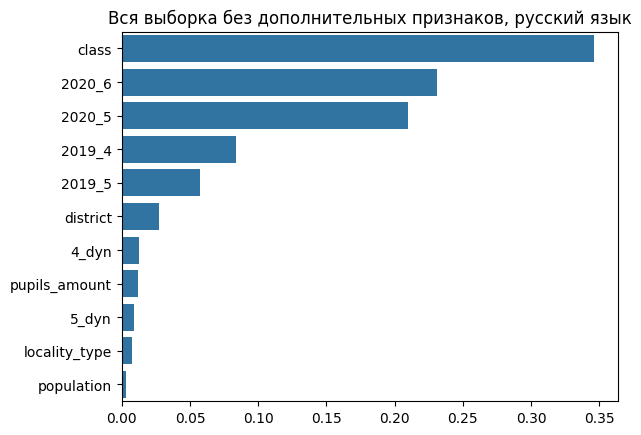

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


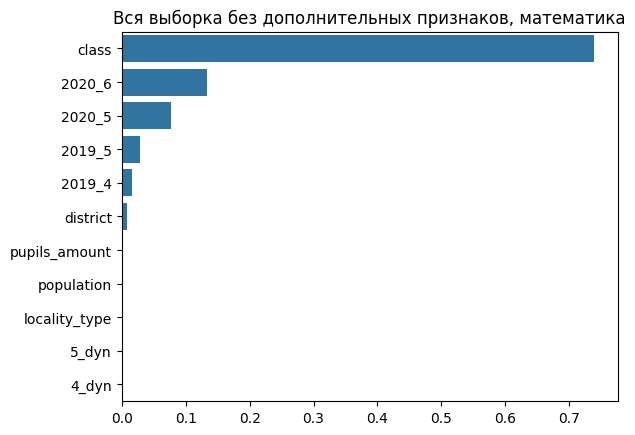

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


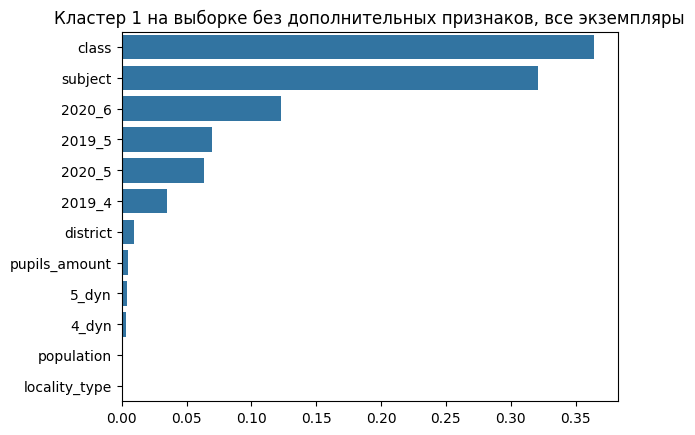

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


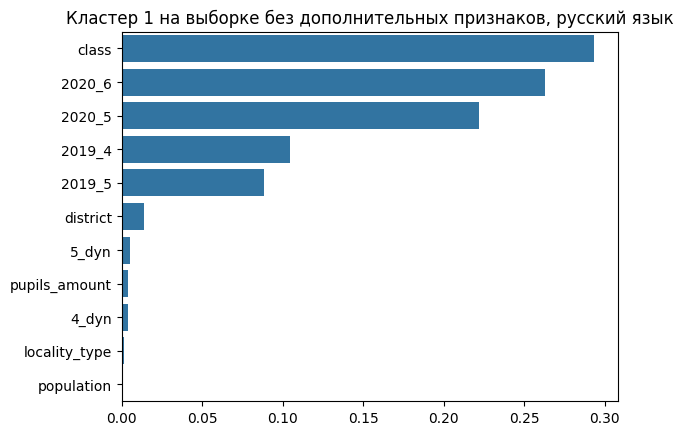

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


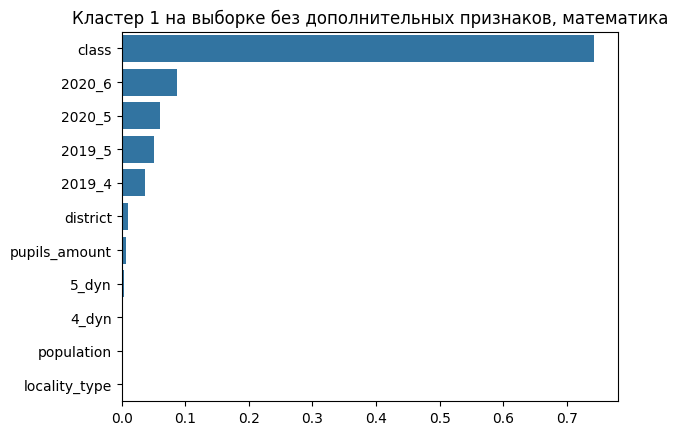

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


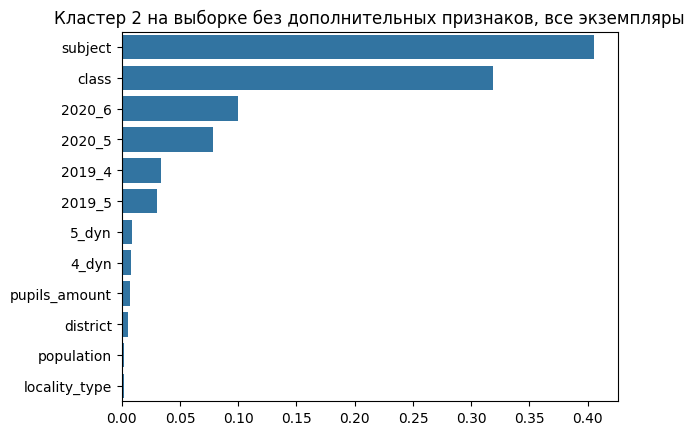

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


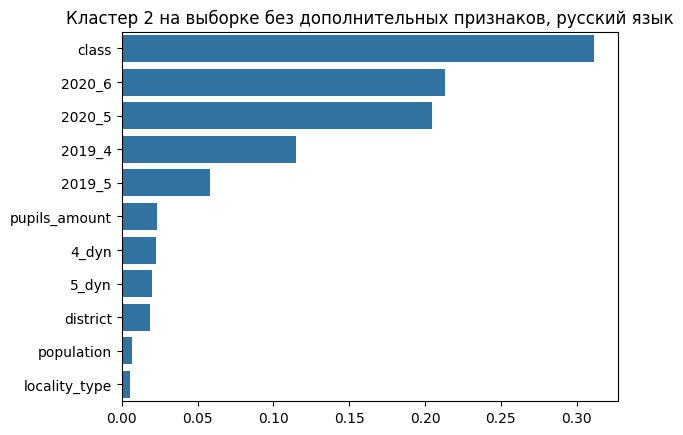

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


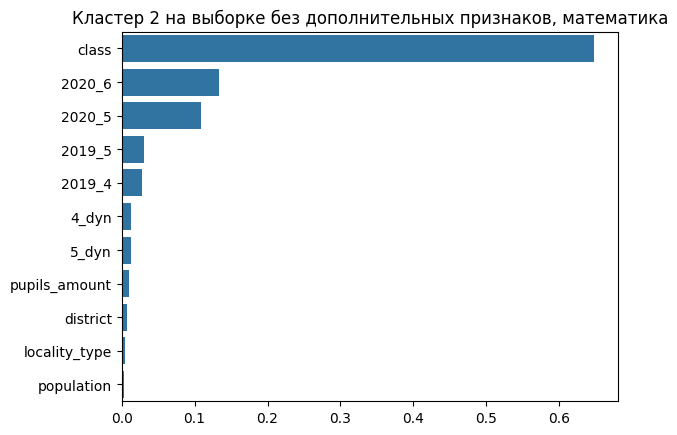

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


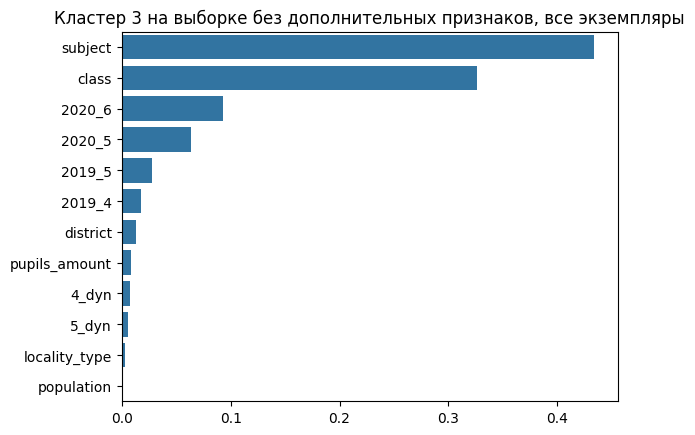

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


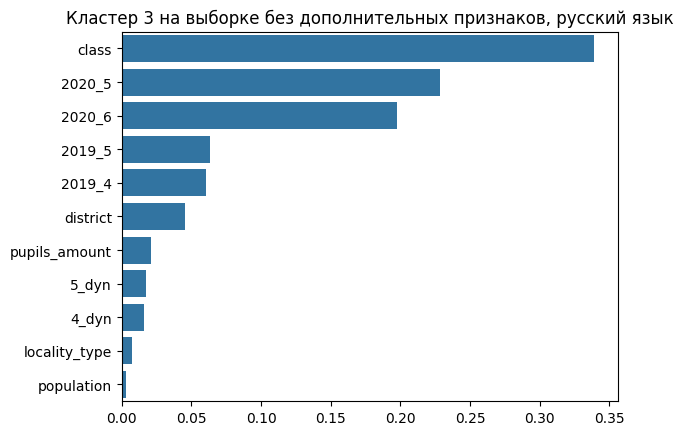

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


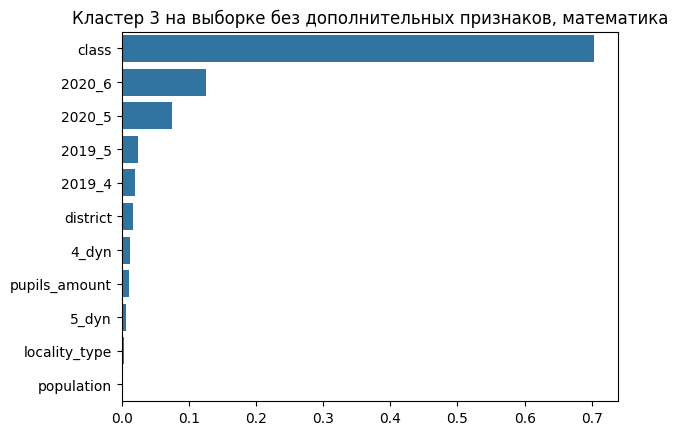

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


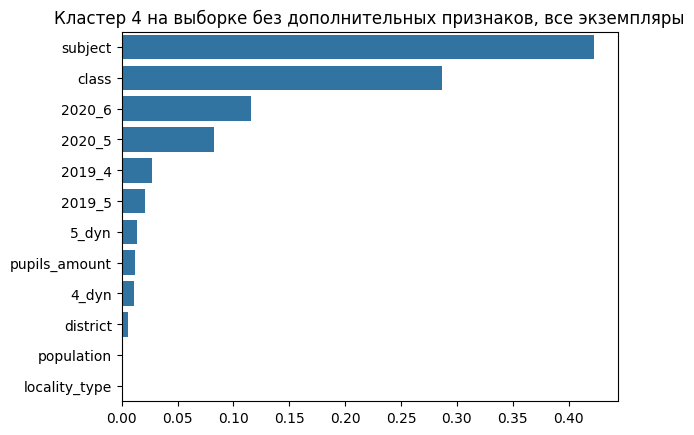

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


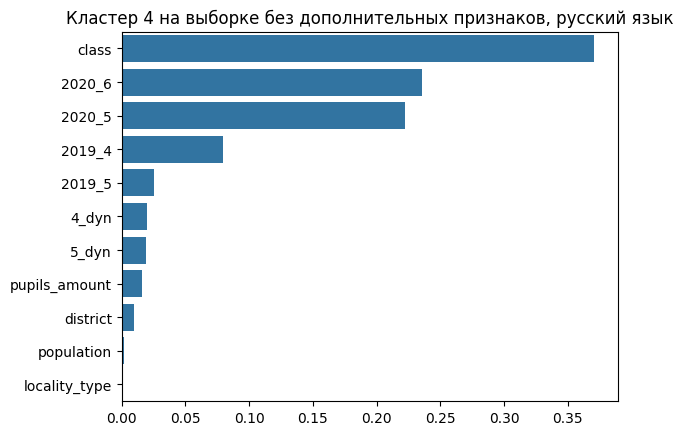

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


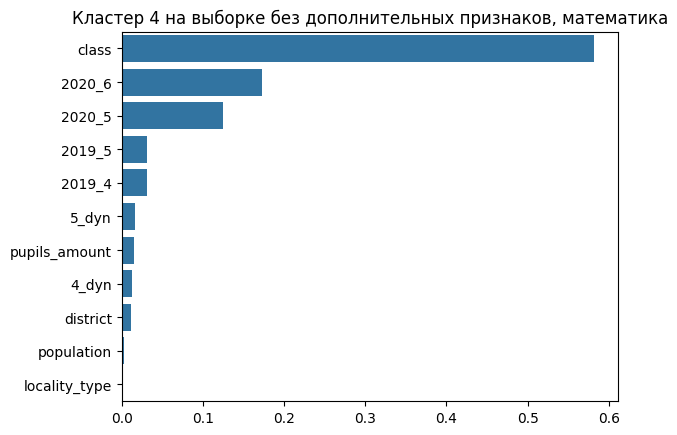

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


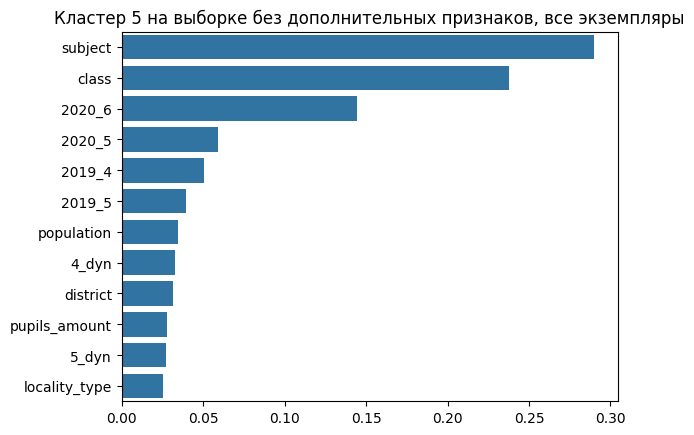

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


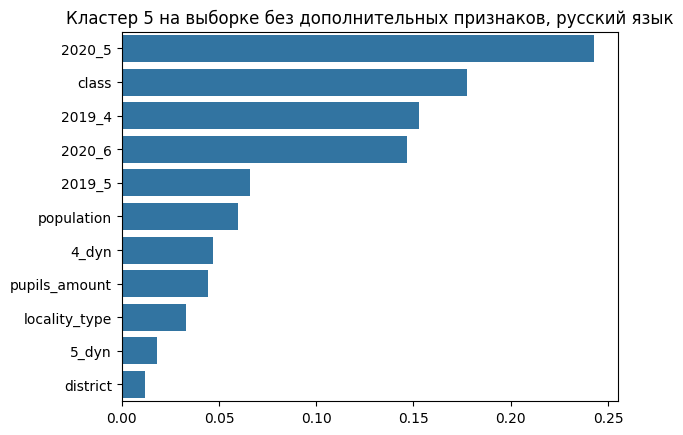

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


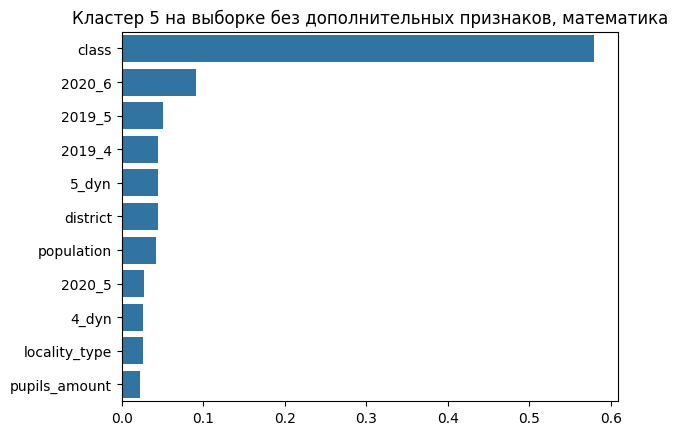

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


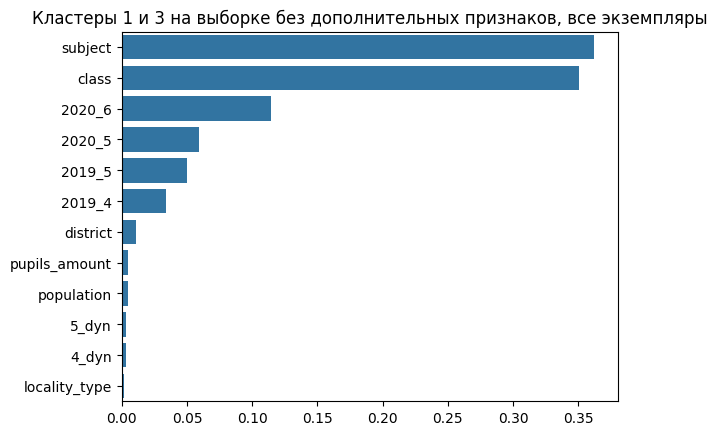

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


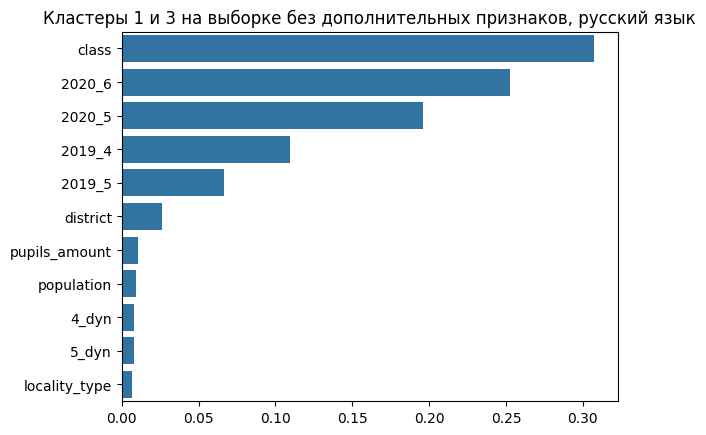

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


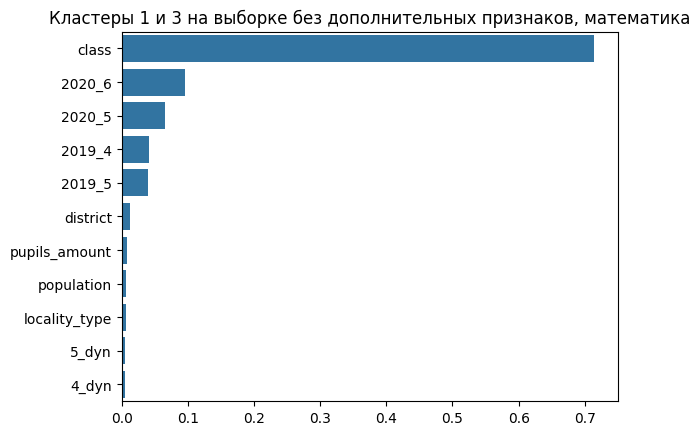

In [ ]:
first_clusters_titles = list(itertools.chain(*[[title + ', все экземпляры', title + ', русский язык', title + ', математика'] for title in list(first_clusters_results.index)]))
plot_feature_importances_on_multiple_models(zip(first_clusters_models, first_clusters_titles))

Видим, что если модель не разделяет русский язык и математику, то самым важным признаком является признак класса, потом предмета, а потом средних баллов за различные года и по различым классам, остальные признаки влияет слабо.

Если идут предсказания по выборке с русским языком, то самым важным признаком является класс, то самыми важными пизнаками с большим отрывом от остальных являются средние баллы и класс. Также какой-никакой вес имеют и все остальные признаки.

Что же касается математики, то самым важным признаком с оченб большим отрывом от остальных является класс. Средние баллы влияют сильно меньше, а у остальных признаков важность околонулевая.

### Использование промежуточных и финальных кластеров

Посмотрим, может добавление новых признаков способствует улучшению результатов

Здесь будут представлены 2 выборки -  в одной при кластеризации использовались признаки зимней и летней температур, а в другой нет

Напишем функцию для получения выборки с кластерами

In [ ]:
def get_sample_with_clusters(path):
    final_clusters = pd.read_csv(path, index_col=0)
    final_clusters.index.name = 'login'
    return final_clusters

In [ ]:
intermediate_clusters = get_sample_with_clusters('second_clustered_success.csv')
final_clusters = get_sample_with_clusters('third_clustered_success.csv')

In [ ]:
intermediate_clusters

location_type   city_name city_population  is_correctional pupils_amount  2019_ru_4  2019_ru_5  2019_ma_4  2019_ma_5  2020_ru_5  2020_ru_6  2020_ma_5  2020_ma_6 district  culture_objects  entertainment_objects  winter_temperature  summer_temperature  rainfall  cluster
login                                                                                                                                                                                                                                                                                   
sch05153598          НПСТ    Ортатюбе    1.000-10.000            False     100 - 500   0.622807   0.683951   0.658333   0.567647   0.488889   0.622222   0.536364   0.575000     СКФО                0                      1                -6.0                24.0       500        2
sch05153203          НПСТ      Тлогоб    1.000-10.000            False       0 - 100   0.684211   0.800000   0.558333   0.583333   0.570370   0.637037   0.600000   0.566667     СКФО                0                      0                -6.0                24.0       500        2
sch05153051          НПСТ       Изано         0-1.000            False       0 - 100   0.745614   0.755556   0.625000   0.600000   0.425000   0.581481   0.656250   0.500000     СКФО                0                      0                -6.0                24.0       500        2
sch05153436          НПСТ      Вперед    1.000-10.000            False     100 - 500   0.671053   0.493651   0.596341   0.533333   0.347670   0.450129   0.342187   0.339773     СКФО                0                      0                -6.0                24.0       500        2
sch05156212          НПСТ        Унты         0-1.000            False       0 - 100   0.649123   0.488889   0.600000   0.716667   0.297778   0.477778   0.450000   0.600000     СКФО                0                      0                -6.0                24.0       500        2
...                   ...         ...             ...              ...           ...        ...        ...        ...        ...        ...        ...        ...        ...      ...              ...                    ...                 ...                 ...       ...      ...
sch05153132          НПСТ    Агачкала         0-1.000            False       0 - 100   0.616228   0.427778   0.416667   0.512500   0.402469   0.494444   0.416667   0.316667     СКФО                0                      0                -6.0                24.0       500        2
sch69193176          НПСТ  Семендяево         0-1.000            False       0 - 100   0.653509   0.718519   0.550000   0.800000   0.494444   0.693333   0.500000   0.700000      ЦФО                0                      0               -10.0                17.5       650        2
sch52123328          НПСТ     Каменки    1.000-10.000            False     100 - 500   0.718144   0.745299   0.625676   0.675000   0.566893   0.532026   0.613636   0.589706      ПФО                0                      0               -12.0                19.0       570        2
sch73130142          НПСТ     Каргино         0-1.000            False       0 - 100   0.567251   0.605556   0.505556   0.475000   0.498765   0.614815   0.495000   0.607143      ПФО                0                      0               -13.0                19.0       400        2
sch64140143          НПСТ   Тургенево         0-1.000            False       0 - 100   0.743421   0.737037   0.637500   0.608333   0.539683   0.622222   0.621429   0.700000      ПФО                0                      0               -12.5                22.0       350        3

[6268 rows x 20 columns]

In [ ]:
final_clusters

location_type   city_name city_population  is_correctional pupils_amount  2019_ru_4  2019_ru_5  2019_ma_4  2019_ma_5  2020_ru_5  2020_ru_6  2020_ma_5  2020_ma_6 district  ent_and_culture_objects ent_and_culture_objects_cat  cluster
login                                                                                                                                                                                                                                              
sch05153598          НПСТ    Ортатюбе    1.000-10.000            False     100 - 500   0.622807   0.683951   0.658333   0.567647   0.488889   0.622222   0.536364   0.575000     СКФО                        3                       0 - 5        0
sch05153203          НПСТ      Тлогоб    1.000-10.000            False       0 - 100   0.684211   0.800000   0.558333   0.583333   0.570370   0.637037   0.600000   0.566667     СКФО                        2                       0 - 5        0
sch05153051          НПСТ       Изано         0-1.000            False       0 - 100   0.745614   0.755556   0.625000   0.600000   0.425000   0.581481   0.656250   0.500000     СКФО                        2                       0 - 5        1
sch05153436          НПСТ      Вперед    1.000-10.000            False     100 - 500   0.671053   0.493651   0.596341   0.533333   0.347670   0.450129   0.342187   0.339773     СКФО                        4                       0 - 5        0
sch05156212          НПСТ        Унты         0-1.000            False       0 - 100   0.649123   0.488889   0.600000   0.716667   0.297778   0.477778   0.450000   0.600000     СКФО                        2                       0 - 5        1
...                   ...         ...             ...              ...           ...        ...        ...        ...        ...        ...        ...        ...        ...      ...                      ...                         ...      ...
sch05153132          НПСТ    Агачкала         0-1.000            False       0 - 100   0.616228   0.427778   0.416667   0.512500   0.402469   0.494444   0.416667   0.316667     СКФО                        1                       0 - 5        1
sch69193176          НПСТ  Семендяево         0-1.000            False       0 - 100   0.653509   0.718519   0.550000   0.800000   0.494444   0.693333   0.500000   0.700000      ЦФО                        0                       0 - 5        1
sch52123328          НПСТ     Каменки    1.000-10.000            False     100 - 500   0.718144   0.745299   0.625676   0.675000   0.566893   0.532026   0.613636   0.589706      ПФО                        4                       0 - 5        0
sch73130142          НПСТ     Каргино         0-1.000            False       0 - 100   0.567251   0.605556   0.505556   0.475000   0.498765   0.614815   0.495000   0.607143      ПФО                        4                       0 - 5        1
sch64140143          НПСТ   Тургенево         0-1.000            False       0 - 100   0.743421   0.737037   0.637500   0.608333   0.539683   0.622222   0.621429   0.700000      ПФО                        3                       0 - 5        1

[6327 rows x 17 columns]

Напишем функцию, которая получает новую тренировочную выборку с доплнительными признаками

In [ ]:
def get_train_sample(clusters, data, new_columns, columns_to_delete=[]):
    return clusters[new_columns].merge(
        data.reset_index().drop(columns=columns_to_delete), how='right',
        left_on=clusters.index, right_on=data.index.str[:11]
    ).drop(columns='key_0').set_index('login').dropna(subset=new_columns)

In [ ]:
new_intermediate_columns = ['culture_objects', 'entertainment_objects', 'winter_temperature', 'summer_temperature', 'rainfall']
small_data_intermediate = get_train_sample(intermediate_clusters, small_data, new_intermediate_columns)

In [ ]:
new_final_columns = ['pupils_amount', 'ent_and_culture_objects_cat']
small_data_final = get_train_sample(final_clusters, small_data, new_final_columns, columns_to_delete=['pupils_amount'])

In [ ]:
small_data_intermediate

culture_objects  entertainment_objects  winter_temperature  summer_temperature  rainfall  class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn        locality_type      population  pupils_amount     district    target
login                                                                                                                                                                                                                                                             
sch01110006_4_rus               0.0                    0.0                 0.9                24.3     700.0      4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648                 НПСТ         0-1.000            141          ЮФО  0.643725
sch01110012_4_rus               0.0                    0.0                 0.9                24.3     700.0      4     rus  0.597039  0.441729  0.466374  0.714035 -0.130665  0.272306                 НПСТ         0-1.000            140          ЮФО  0.616228
sch01110019_4_rus               0.0                    0.0                 0.9                24.3     700.0      4     rus  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705                 НПСТ    1.000-10.000            251          ЮФО  0.653110
sch01110024_4_rus               2.0                    0.0                 0.9                24.3     700.0      4     rus  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514                 НПСТ  10.000-100.000            896          ЮФО  0.731955
sch01110031_4_rus               0.0                    0.0                 0.9                24.3     700.0      4     rus  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540                 НПСТ    1.000-10.000            162          ЮФО  0.673375
...                             ...                    ...                 ...                 ...       ...    ...     ...       ...       ...       ...       ...       ...       ...                  ...             ...            ...          ...       ...
sch92120045_6_math              0.0                    1.0                 3.0                22.5     450.0      6    math  0.741045  0.556349  0.607576  0.565254 -0.133469  0.008905  Столица субъекта РФ        100.000+            772  Севастополь  0.422414
sch92120052_6_math              3.0                    0.0                 3.0                22.5     450.0      6    math  0.621429  0.522727  0.529545  0.346000 -0.091883 -0.176727  Столица субъекта РФ        100.000+            295  Севастополь  0.358333
sch92120059_6_math              1.0                    1.0                 3.0                22.5     450.0      6    math  0.470000  0.308621  0.495833  0.286000  0.025833 -0.022621  Столица субъекта РФ        100.000+            315  Севастополь  0.220690
sch92122004_6_math              0.0                    1.0                 3.0                22.5     450.0      6    math  0.680769  0.628571  0.562500  0.511111 -0.118269 -0.117460  Столица субъекта РФ        100.000+            114  Севастополь  0.288889
sch92126001_6_math             41.0                    1.0                 3.0                22.5     450.0      6    math  0.703289  0.605128  0.587736  0.553731 -0.115554 -0.051397  Столица субъекта РФ        100.000+           1085  Севастополь  0.491667

[37301 rows x 18 columns]

In [ ]:
small_data_final

pupils_amount ent_and_culture_objects_cat  class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn        locality_type      population     district    target
login                                                                                                                                                                                              
sch01110006_4_rus      100 - 500                       0 - 5      4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648                 НПСТ         0-1.000          ЮФО  0.643725
sch01110012_4_rus      100 - 500                       0 - 5      4     rus  0.597039  0.441729  0.466374  0.714035 -0.130665  0.272306                 НПСТ         0-1.000          ЮФО  0.616228
sch01110019_4_rus      100 - 500                       0 - 5      4     rus  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705                 НПСТ    1.000-10.000          ЮФО  0.653110
sch01110024_4_rus     500 - 1000                     30 - 40      4     rus  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514                 НПСТ  10.000-100.000          ЮФО  0.731955
sch01110031_4_rus      100 - 500                       0 - 5      4     rus  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540                 НПСТ    1.000-10.000          ЮФО  0.673375
...                          ...                         ...    ...     ...       ...       ...       ...       ...       ...       ...                  ...             ...          ...       ...
sch92120045_6_math    500 - 1000                         40+      6    math  0.741045  0.556349  0.607576  0.565254 -0.133469  0.008905  Столица субъекта РФ        100.000+  Севастополь  0.422414
sch92120052_6_math     100 - 500                       0 - 5      6    math  0.621429  0.522727  0.529545  0.346000 -0.091883 -0.176727  Столица субъекта РФ        100.000+  Севастополь  0.358333
sch92120059_6_math     100 - 500                       0 - 5      6    math  0.470000  0.308621  0.495833  0.286000  0.025833 -0.022621  Столица субъекта РФ        100.000+  Севастополь  0.220690
sch92122004_6_math     100 - 500                     10 - 30      6    math  0.680769  0.628571  0.562500  0.511111 -0.118269 -0.117460  Столица субъекта РФ        100.000+  Севастополь  0.288889
sch92126001_6_math         1000+                     10 - 30      6    math  0.703289  0.605128  0.587736  0.553731 -0.115554 -0.051397  Столица субъекта РФ        100.000+  Севастополь  0.491667

[37649 rows x 14 columns]

Признаки, отвечающие за количество каких-то объектов (количество культурных объектов, объектов развлечений) нужно привести к целочисленному типу

In [ ]:
for integer_column in ['culture_objects', 'entertainment_objects']:
    small_data_intermediate[integer_column] = small_data_intermediate[integer_column].astype(int)

In [ ]:
small_data_intermediate

culture_objects  entertainment_objects  winter_temperature  summer_temperature  rainfall  class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn        locality_type      population  pupils_amount     district    target
login                                                                                                                                                                                                                                                             
sch01110006_4_rus                 0                      0                 0.9                24.3     700.0      4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648                 НПСТ         0-1.000            141          ЮФО  0.643725
sch01110012_4_rus                 0                      0                 0.9                24.3     700.0      4     rus  0.597039  0.441729  0.466374  0.714035 -0.130665  0.272306                 НПСТ         0-1.000            140          ЮФО  0.616228
sch01110019_4_rus                 0                      0                 0.9                24.3     700.0      4     rus  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705                 НПСТ    1.000-10.000            251          ЮФО  0.653110
sch01110024_4_rus                 2                      0                 0.9                24.3     700.0      4     rus  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514                 НПСТ  10.000-100.000            896          ЮФО  0.731955
sch01110031_4_rus                 0                      0                 0.9                24.3     700.0      4     rus  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540                 НПСТ    1.000-10.000            162          ЮФО  0.673375
...                             ...                    ...                 ...                 ...       ...    ...     ...       ...       ...       ...       ...       ...       ...                  ...             ...            ...          ...       ...
sch92120045_6_math                0                      1                 3.0                22.5     450.0      6    math  0.741045  0.556349  0.607576  0.565254 -0.133469  0.008905  Столица субъекта РФ        100.000+            772  Севастополь  0.422414
sch92120052_6_math                3                      0                 3.0                22.5     450.0      6    math  0.621429  0.522727  0.529545  0.346000 -0.091883 -0.176727  Столица субъекта РФ        100.000+            295  Севастополь  0.358333
sch92120059_6_math                1                      1                 3.0                22.5     450.0      6    math  0.470000  0.308621  0.495833  0.286000  0.025833 -0.022621  Столица субъекта РФ        100.000+            315  Севастополь  0.220690
sch92122004_6_math                0                      1                 3.0                22.5     450.0      6    math  0.680769  0.628571  0.562500  0.511111 -0.118269 -0.117460  Столица субъекта РФ        100.000+            114  Севастополь  0.288889
sch92126001_6_math               41                      1                 3.0                22.5     450.0      6    math  0.703289  0.605128  0.587736  0.553731 -0.115554 -0.051397  Столица субъекта РФ        100.000+           1085  Севастополь  0.491667

[37301 rows x 18 columns]

Получим итоговые кластеры

In [ ]:
second_clusters = get_clusters(intermediate_clusters, aux_data)
third_clusters = get_clusters(final_clusters, aux_data)

#### Обучение на промежуточных кластерах

Обучим модель на всей выборке

In [ ]:
second_clusters_models = []
second_clusters_results = pd.DataFrame(columns=['Все экземпляры', 'Русский язык', 'Математика', 'Русский язык + математика'])

In [ ]:
global_models, second_clusters_results = train_cycle(
    small_data_intermediate, small_data_intermediate,
    mean_squared_error,
    'Вся выборка с дополнительными признаками (1 вариант)',
    second_clusters_results, n_trials=2, return_shapes=False,
    return_mean_and_std=False, reduction=False, need_norm=need_norm
)
second_clusters_models.extend(global_models)

[I 2024-05-12 22:46:02,308] A new study created in memory with name: Вся выборка с дополнительными признаками (1 вариант), все экземпляры


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-12 22:46:04,816] Trial 0 finished with value: 0.006581584402394997 and parameters: {'n_estimators': 143, 'l2_leaf_reg': 3.4342215813541728, 'max_depth': 6, 'max_leaves': 5}. Best is trial 0 with value: 0.006581584402394997.
[I 2024-05-12 22:46:08,647] Trial 1 finished with value: 0.00973338929797549 and parameters: {'n_estimators': 395, 'l2_leaf_reg': 0.674043580571183, 'max_depth': 5, 'max_leaves': 2}. Best is trial 0 with value: 0.006581584402394997.


[I 2024-05-12 22:46:13,548] A new study created in memory with name: Вся выборка с дополнительными признаками (1 вариант), русский язык


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-12 22:46:18,442] Trial 0 finished with value: 0.006183864714809644 and parameters: {'n_estimators': 840, 'l2_leaf_reg': 3.445562240052643, 'max_depth': 2, 'max_leaves': 21}. Best is trial 0 with value: 0.006183864714809644.
[I 2024-05-12 22:46:29,206] Trial 1 finished with value: 0.006028810002118156 and parameters: {'n_estimators': 752, 'l2_leaf_reg': 2.5630343548144503, 'max_depth': 17, 'max_leaves': 6}. Best is trial 1 with value: 0.006028810002118156.


[I 2024-05-12 22:46:36,892] A new study created in memory with name: Вся выборка с дополнительными признаками (1 вариант), математика


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-12 22:46:39,309] Trial 0 finished with value: 0.005295422418141409 and parameters: {'n_estimators': 196, 'l2_leaf_reg': 3.1873057508298053, 'max_depth': 3, 'max_leaves': 7}. Best is trial 0 with value: 0.005295422418141409.
[I 2024-05-12 22:46:44,061] Trial 1 finished with value: 0.005280149731718791 and parameters: {'n_estimators': 303, 'l2_leaf_reg': 3.272119163709625, 'max_depth': 19, 'max_leaves': 5}. Best is trial 1 with value: 0.005280149731718791.


Обучим модель на кластерах

In [ ]:
second_clusters_models, second_clusters_results, second_clusters_test_shapes = train_clusters(
    small_data_intermediate, second_clusters,
    second_clusters_models, second_clusters_results,
    desc=['Кластер', 'на выборке с дополнительными признаками (1 вариант)'],
    need_correction_index=False
)

[I 2024-05-12 23:05:35,841] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (1 вариант), все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:05:39,889] Trial 0 finished with value: 0.007482019767514607 and parameters: {'n_estimators': 488, 'l2_leaf_reg': 4.32073731878164, 'max_depth': 13, 'max_leaves': 5}. Best is trial 0 with value: 0.007482019767514607.
[I 2024-05-12 23:05:58,138] Trial 1 finished with value: 0.007063410144891195 and parameters: {'n_estimators': 807, 'l2_leaf_reg': 1.0857074751692168, 'max_depth': 18, 'max_leaves': 42}. Best is trial 1 with value: 0.007063410144891195.
[I 2024-05-12 23:05:59,305] Trial 2 finished with value: 0.011463637084042477 and parameters: {'n_estimators': 442, 'l2_leaf_reg': 0.53712209010434, 'max_depth': 5, 'max_leaves': 2}. Best is trial 1 with value: 0.007063410144891195.
[I 2024-05-12 23:06:00,343] Trial 3 finished with value: 0.007885198870016064 and parameters: {'n_estimators': 350, 'l2_leaf_reg': 3.74793663933398, 'max_depth': 2, 'max_leaves': 5}. Best is trial 1 with value: 0.007063410144891195.
[I 2024-05-12 23:06:07,041] Trial 4 finished with value: 0.0070

[I 2024-05-12 23:09:10,106] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (1 вариант), русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:09:18,167] Trial 0 finished with value: 0.008207667969729682 and parameters: {'n_estimators': 962, 'l2_leaf_reg': 2.2904035519610084, 'max_depth': 14, 'max_leaves': 13}. Best is trial 0 with value: 0.008207667969729682.
[I 2024-05-12 23:09:21,027] Trial 1 finished with value: 0.008297073234581098 and parameters: {'n_estimators': 951, 'l2_leaf_reg': 3.6175304142214064, 'max_depth': 7, 'max_leaves': 5}. Best is trial 0 with value: 0.008207667969729682.
[I 2024-05-12 23:09:22,180] Trial 2 finished with value: 0.008281563297510307 and parameters: {'n_estimators': 334, 'l2_leaf_reg': 4.574524058795034, 'max_depth': 4, 'max_leaves': 7}. Best is trial 0 with value: 0.008207667969729682.
[I 2024-05-12 23:09:34,276] Trial 3 finished with value: 0.008087341860046572 and parameters: {'n_estimators': 625, 'l2_leaf_reg': 0.9130836888442544, 'max_depth': 10, 'max_leaves': 31}. Best is trial 3 with value: 0.008087341860046572.
[I 2024-05-12 23:09:34,849] Trial 4 finished with value: 

[I 2024-05-12 23:11:05,249] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (1 вариант), математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:11:05,905] Trial 0 finished with value: 0.0064095562840492904 and parameters: {'n_estimators': 129, 'l2_leaf_reg': 4.320770756176257, 'max_depth': 4, 'max_leaves': 63}. Best is trial 0 with value: 0.0064095562840492904.
[I 2024-05-12 23:11:08,747] Trial 1 finished with value: 0.006227460400898101 and parameters: {'n_estimators': 716, 'l2_leaf_reg': 3.8991859992552986, 'max_depth': 2, 'max_leaves': 38}. Best is trial 1 with value: 0.006227460400898101.
[I 2024-05-12 23:11:11,282] Trial 2 finished with value: 0.006195008596760592 and parameters: {'n_estimators': 907, 'l2_leaf_reg': 0.7529461936864852, 'max_depth': 2, 'max_leaves': 8}. Best is trial 2 with value: 0.006195008596760592.
[I 2024-05-12 23:11:11,762] Trial 3 finished with value: 0.0070158964584213935 and parameters: {'n_estimators': 276, 'l2_leaf_reg': 4.650825211901237, 'max_depth': 2, 'max_leaves': 2}. Best is trial 2 with value: 0.006195008596760592.
[I 2024-05-12 23:11:12,964] Trial 4 finished with value: 

In [ ]:
second_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка с дополнительными признаками (1 вариант)                 0.006225      0.006111    0.004772                   0.005439
Кластер 1 на выборке с дополнительными признаками (1 вариант)        0.004938      0.004959    0.004520                   0.004739
Кластер 2 на выборке с дополнительными признаками (1 вариант)        0.003739      0.004262    0.003299                   0.003778
Кластер 3 на выборке с дополнительными признаками (1 вариант)        0.007427      0.008116    0.006561                   0.007339
Кластер 4 на выборке с дополнительными признаками (1 вариант)        0.007163      0.008454    0.006046                   0.007252

Результаты вышли чуть хуже для всей выборки, чем без дополнительных признаков.

Также видим, что хорошо отработали первый и второй кластеры, поэтому попробуем их склеить в один (они занимают порядка 41% от всей выборки)

In [ ]:
second_clusters_rus_shapes, second_clusters_math_shapes = list(zip(*second_clusters_test_shapes))
(second_clusters_rus_shapes[0] + second_clusters_rus_shapes[1] + second_clusters_math_shapes[0]
      + second_clusters_math_shapes[1]) / (sum(second_clusters_rus_shapes) + sum(second_clusters_math_shapes))

0.4139926354550237

In [ ]:
first_and_second_clusters = pd.concat((second_clusters[0], second_clusters[1])).sample(frac=1)
first_and_second_clusters

locality_type      population  correction  pupils_amount district
login                                                                        
sch27173172         Город        100.000+           0           1438     ДВФО
sch42126011         Город        100.000+           0            987      СФО
sch82120851         Город        100.000+           0            408      ЮФО
sch23133995         Город        100.000+           0           3676      ЮФО
sch36163129         Город        100.000+           0            476      ЦФО
...                   ...             ...         ...            ...      ...
sch18183450         Город  10.000-100.000           0            651      ПФО
sch38183619          НПГТ    1.000-10.000           0            388      СФО
sch82121504          НПСТ    1.000-10.000           0            352      ЮФО
sch38183819          НПСТ    1.000-10.000           0            571      СФО
sch09193046          НПСТ    1.000-10.000           0            370     СКФО

[2591 rows x 5 columns]

Здесь мы предскажем с помощью получившихся значений результаты для первого и второго кластеров для русского языка и математики отдельно

In [ ]:
local_models, second_clusters_results = train_cycle(
    small_data_intermediate, first_and_second_clusters,
    mean_squared_error,
    f'Кластеры 1 и 2 на выборке с дополнительными признаками (1 вариант)',
    second_clusters_results, return_shapes=False,
    return_mean_and_std=False, need_norm=need_norm
)
second_clusters_models.extend(local_models)

[I 2024-05-12 23:15:01,412] A new study created in memory with name: Кластеры 1 и 2 на выборке с дополнительными признаками (1 вариант), все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:15:04,015] Trial 0 finished with value: 0.005203327428457218 and parameters: {'n_estimators': 421, 'l2_leaf_reg': 3.6746235363259108, 'max_depth': 5, 'max_leaves': 3}. Best is trial 0 with value: 0.005203327428457218.
[I 2024-05-12 23:15:04,748] Trial 1 finished with value: 0.005442668658233543 and parameters: {'n_estimators': 123, 'l2_leaf_reg': 3.7891437853706567, 'max_depth': 2, 'max_leaves': 10}. Best is trial 0 with value: 0.005203327428457218.
[I 2024-05-12 23:15:14,252] Trial 2 finished with value: 0.004106040925291321 and parameters: {'n_estimators': 816, 'l2_leaf_reg': 0.284840793698448, 'max_depth': 11, 'max_leaves': 6}. Best is trial 2 with value: 0.004106040925291321.
[I 2024-05-12 23:15:32,553] Trial 3 finished with value: 0.004009893630114701 and parameters: {'n_estimators': 923, 'l2_leaf_reg': 4.325576595575513, 'max_depth': 7, 'max_leaves': 24}. Best is trial 3 with value: 0.004009893630114701.
[I 2024-05-12 23:15:42,001] Trial 4 finished with value: 0.

[I 2024-05-12 23:20:01,937] A new study created in memory with name: Кластеры 1 и 2 на выборке с дополнительными признаками (1 вариант), русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:20:03,234] Trial 0 finished with value: 0.004622631134038939 and parameters: {'n_estimators': 427, 'l2_leaf_reg': 3.860843378175722, 'max_depth': 2, 'max_leaves': 26}. Best is trial 0 with value: 0.004622631134038939.
[I 2024-05-12 23:20:10,298] Trial 1 finished with value: 0.004401120546190583 and parameters: {'n_estimators': 482, 'l2_leaf_reg': 1.0544598118126935, 'max_depth': 11, 'max_leaves': 30}. Best is trial 1 with value: 0.004401120546190583.
[I 2024-05-12 23:20:12,829] Trial 2 finished with value: 0.004683006291037931 and parameters: {'n_estimators': 539, 'l2_leaf_reg': 3.399544612142197, 'max_depth': 3, 'max_leaves': 3}. Best is trial 1 with value: 0.004401120546190583.
[I 2024-05-12 23:20:16,851] Trial 3 finished with value: 0.004790086358256953 and parameters: {'n_estimators': 832, 'l2_leaf_reg': 2.0126279257553294, 'max_depth': 7, 'max_leaves': 2}. Best is trial 1 with value: 0.004401120546190583.
[I 2024-05-12 23:20:20,151] Trial 4 finished with value: 0.

[I 2024-05-12 23:22:38,577] A new study created in memory with name: Кластеры 1 и 2 на выборке с дополнительными признаками (1 вариант), математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-12 23:22:42,524] Trial 0 finished with value: 0.0036119129557450076 and parameters: {'n_estimators': 744, 'l2_leaf_reg': 0.558425684112528, 'max_depth': 2, 'max_leaves': 5}. Best is trial 0 with value: 0.0036119129557450076.
[I 2024-05-12 23:22:43,329] Trial 1 finished with value: 0.0038385678618321276 and parameters: {'n_estimators': 199, 'l2_leaf_reg': 2.739449606097258, 'max_depth': 3, 'max_leaves': 4}. Best is trial 0 with value: 0.0036119129557450076.
[I 2024-05-12 23:22:45,775] Trial 2 finished with value: 0.0035917676116360093 and parameters: {'n_estimators': 565, 'l2_leaf_reg': 4.946168808290843, 'max_depth': 3, 'max_leaves': 32}. Best is trial 2 with value: 0.0035917676116360093.
[I 2024-05-12 23:22:48,035] Trial 3 finished with value: 0.0036824822092980914 and parameters: {'n_estimators': 652, 'l2_leaf_reg': 0.5295261643508734, 'max_depth': 7, 'max_leaves': 3}. Best is trial 2 with value: 0.0035917676116360093.
[I 2024-05-12 23:22:50,150] Trial 4 finished with valu

In [ ]:
second_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка с дополнительными признаками (1 вариант)                      0.006225      0.006111    0.004772                   0.005439
Кластер 1 на выборке с дополнительными признаками (1 вариант)             0.004938      0.004959    0.004520                   0.004739
Кластер 2 на выборке с дополнительными признаками (1 вариант)             0.003739      0.004262    0.003299                   0.003778
Кластер 3 на выборке с дополнительными признаками (1 вариант)             0.007427      0.008116    0.006561                   0.007339
Кластер 4 на выборке с дополнительными признаками (1 вариант)             0.007163      0.008454    0.006046                   0.007252
Кластеры 1 и 2 на выборке с дополнительными признаками (1 вариант)        0.003537      0.003988    0.003030                   0.003508

Видим, что и по русскому языку и без разделения на предметы результаты лучше у слияния первого и второго кластеров, чем у каждого их них по отдельности, а в математике наоборот. Поэтому их слияние скорее оправдано, чем нет

Теперь предскажем с помощью получившихся моделей результаты на всей тестовой выборке

In [ ]:
second_clusters_rus_mse = sum(second_clusters_results['Русский язык'][1:-1].values * np.array(second_clusters_rus_shapes)) / sum(second_clusters_rus_shapes)
second_clusters_math_mse = sum(second_clusters_results['Математика'][1:-1].values * np.array(second_clusters_math_shapes)) / sum(second_clusters_math_shapes)
second_clusters_global_mse = sum(second_clusters_results['Русский язык + математика'][1:-1].values
                  * (np.array(second_clusters_rus_shapes) + np.array(second_clusters_math_shapes))) / (sum(second_clusters_rus_shapes)
                   + sum(second_clusters_math_shapes))

In [ ]:
clusters_results.loc['Все кластеры на выборке с дополнительными признаками (1 вариант)'] = [second_clusters_rus_mse, second_clusters_math_mse, second_clusters_global_mse]

In [ ]:
clusters_results

Русский язык  Математика  Русский язык + математика
Все кластеры на выборке без дополнительных признаков                  0.006030    0.004983                   0.005507
Все кластеры на выборке с дополнительными признаками (1 вариант)      0.006645    0.005197                   0.005920

Видим, что добавление дополнительных признаков не улучшает результаты моделей ни в чём, возможно с другими кластерами будет лучше

Проанализируем важность признаков наших моделей

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


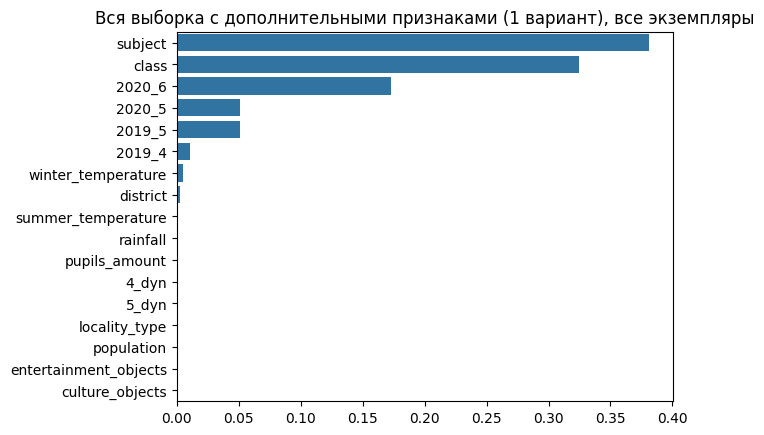

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


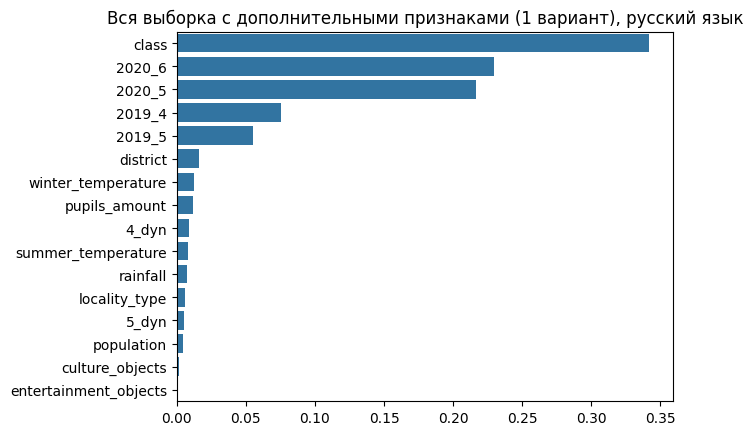

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


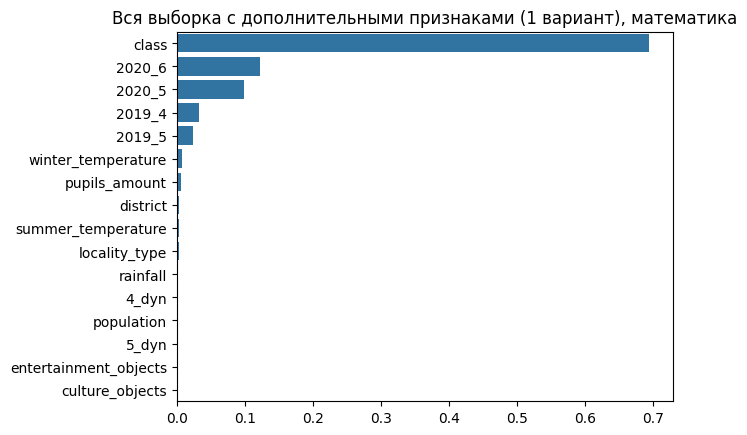

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


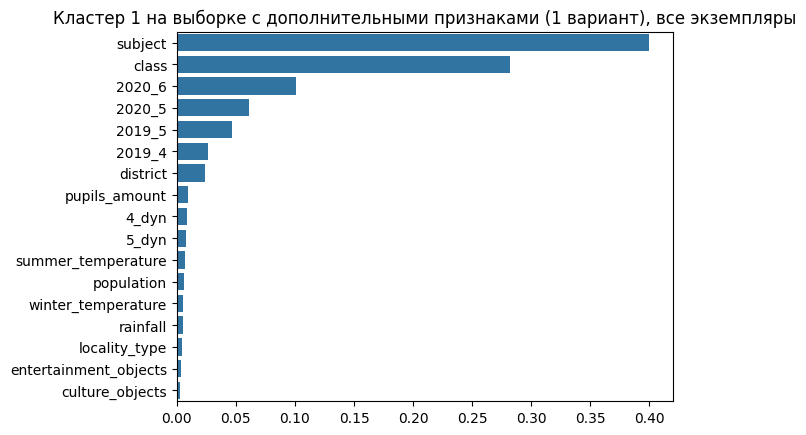

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


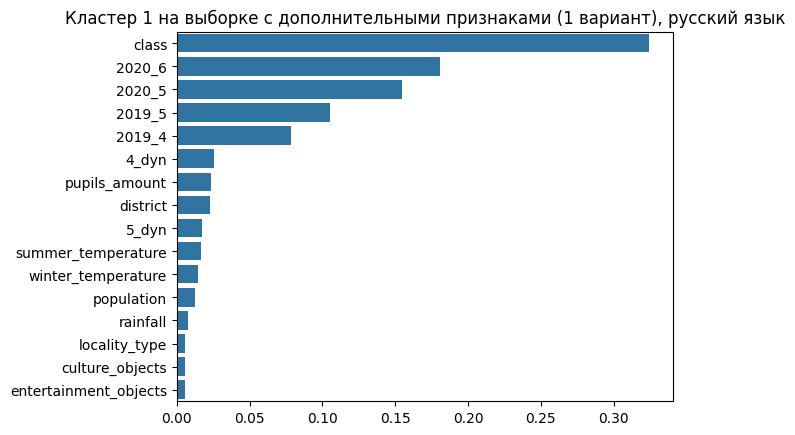

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


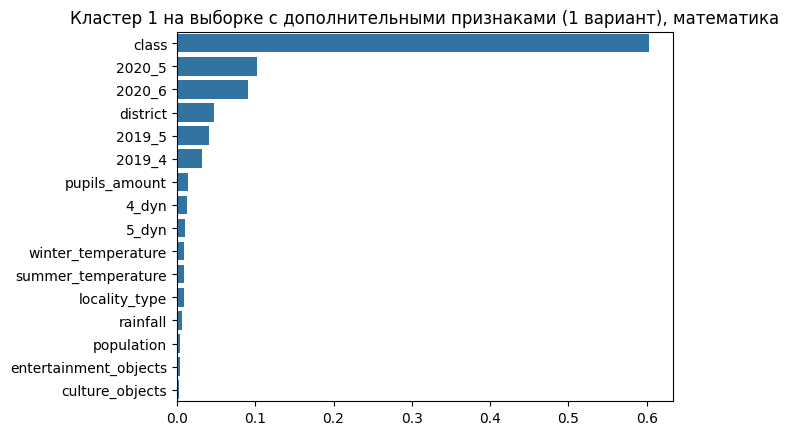

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


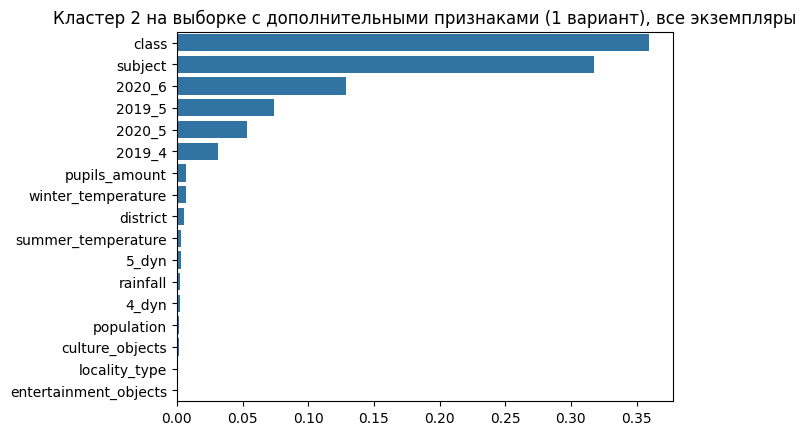

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


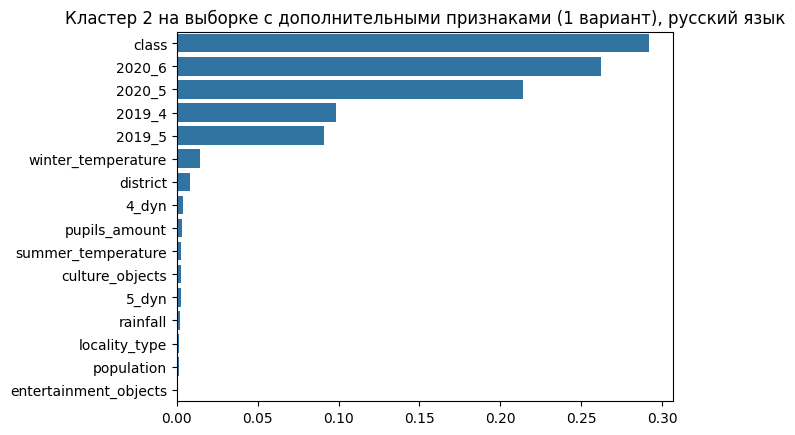

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


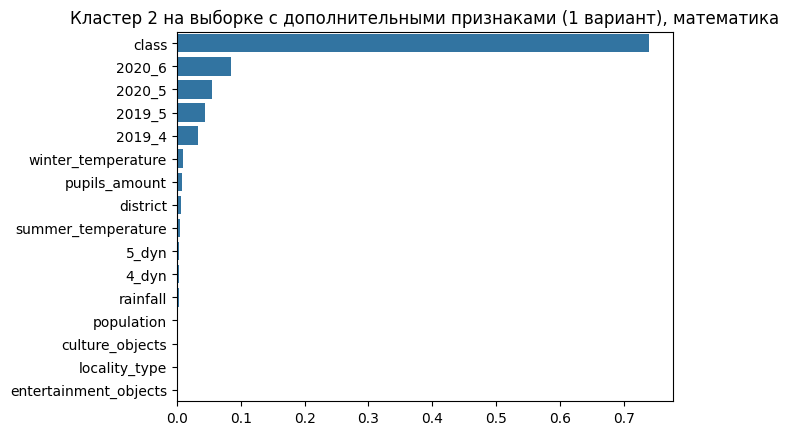

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


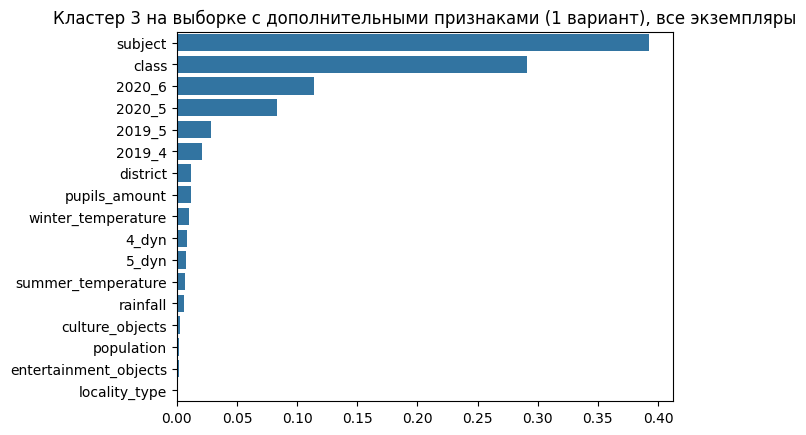

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


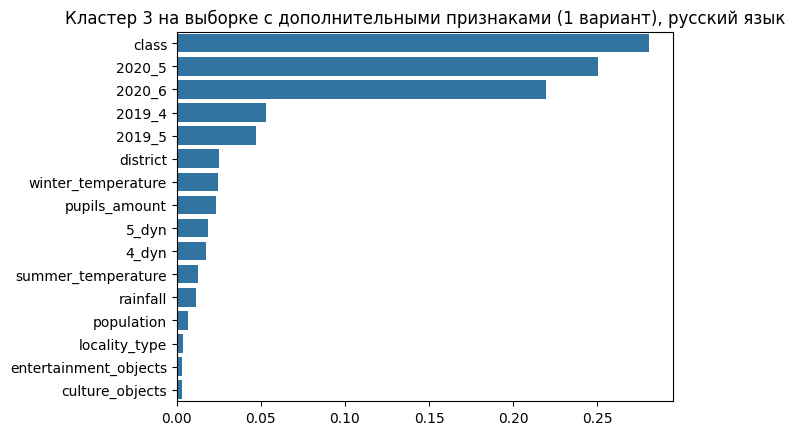

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


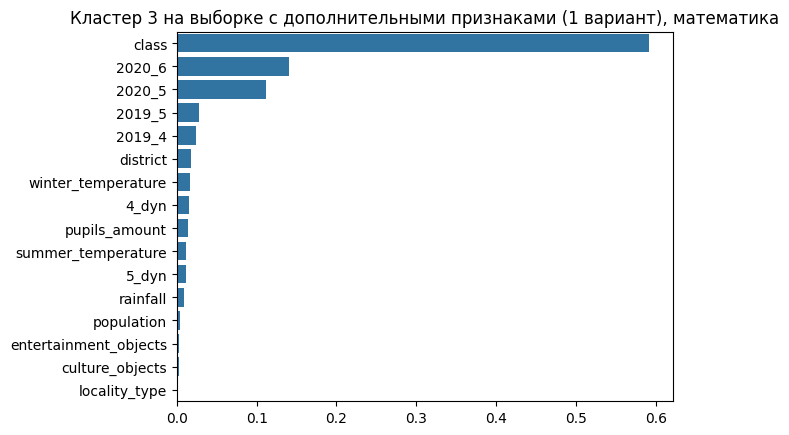

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


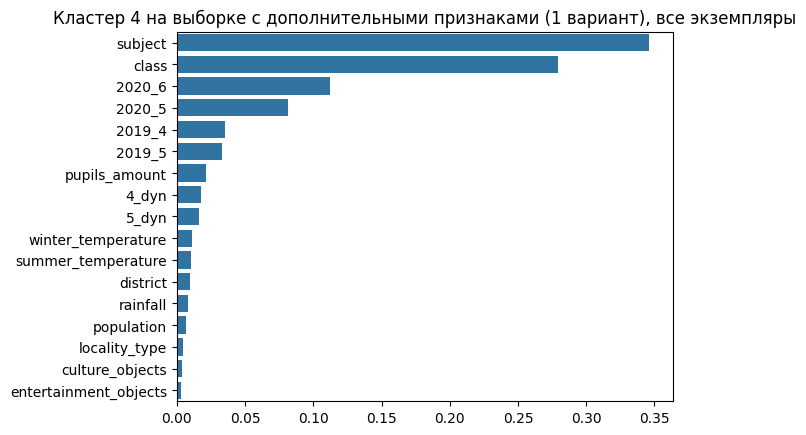

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


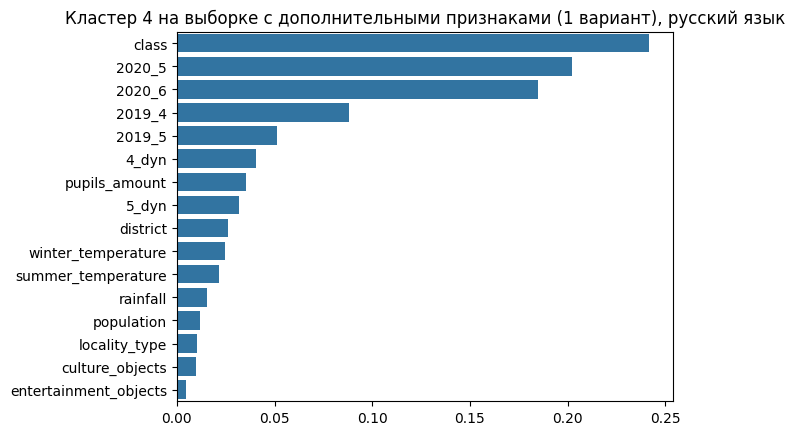

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


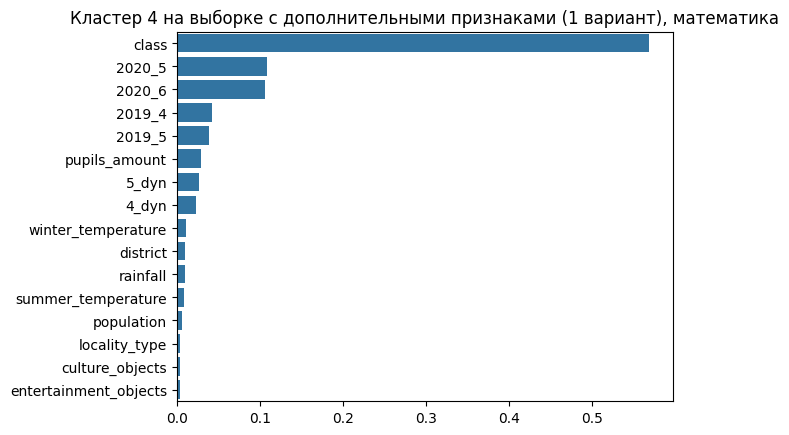

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


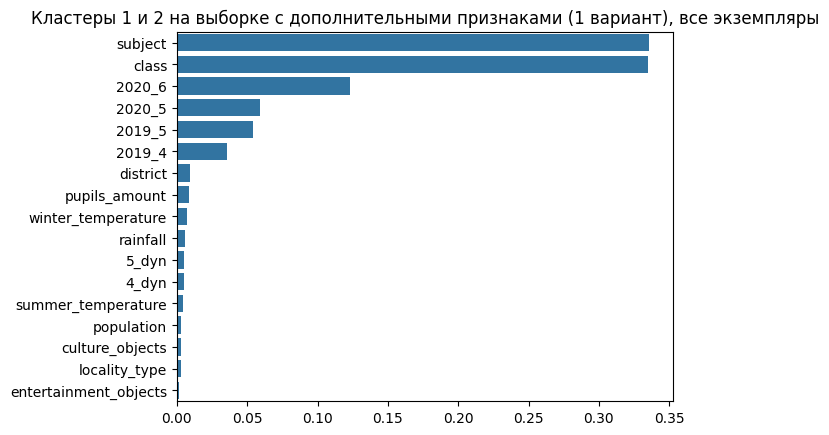

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


In [ ]:
second_clusters_titles = list(itertools.chain(*[[title + ', все экземпляры', title + ', русский язык', title + ', математика'] for title in list(second_clusters_results.index)]))
plot_feature_importances_on_multiple_models(zip(second_clusters_models, second_clusters_titles))

Если рассматривать старые признаки, то ситуация такая же, как и в предыдущем случае, где признаки задействованы не были.

Что же касается новых признаков, то более сильное влияние на модель оказывают признаки, связанные с погодой - больше всего летняя и зимняя температура, в меньшей степени осадки.

Количество культурных объектов и объектов досуга оказывает весьма слабое влияние на итоговый результат, что немного удивительно.

#### Обучение на финальных кластерах

Появились новые категориальные признаки, их надо учесть пи обучении модели

In [ ]:
categorical_columns.extend(['pupils_amount', 'ent_and_culture_objects_cat'])

Также исчезли численные признаки, связанные с температурой

In [ ]:
third_clusters_models = []
third_clusters_results = pd.DataFrame(columns=['Все экземпляры', 'Русский язык', 'Математика', 'Русский язык + математика'])

Обучим модель на всей выборке

In [ ]:
global_models, third_clusters_results = train_cycle(
    small_data_final, small_data_final,
    mean_squared_error,
    'Вся выборка с дополнительными признаками (2 вариант)',
    third_clusters_results, n_trials=2, return_shapes=False,
    return_mean_and_std=False, reduction=False, need_norm=need_norm
)
third_clusters_models.extend(global_models)

[I 2024-05-13 00:32:12,668] A new study created in memory with name: Вся выборка с дополнительными признаками (2 вариант), все экземпляры


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-13 00:32:49,758] Trial 0 finished with value: 0.00565116201212644 and parameters: {'n_estimators': 833, 'l2_leaf_reg': 2.324149641375798, 'max_depth': 15, 'max_leaves': 27}. Best is trial 0 with value: 0.00565116201212644.
[I 2024-05-13 00:32:52,753] Trial 1 finished with value: 0.006931949408807434 and parameters: {'n_estimators': 163, 'l2_leaf_reg': 1.193981039999987, 'max_depth': 2, 'max_leaves': 4}. Best is trial 0 with value: 0.00565116201212644.


[I 2024-05-13 00:33:28,958] A new study created in memory with name: Вся выборка с дополнительными признаками (2 вариант), русский язык


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-13 00:33:30,637] Trial 0 finished with value: 0.007310258781215482 and parameters: {'n_estimators': 301, 'l2_leaf_reg': 0.3697704062010674, 'max_depth': 4, 'max_leaves': 2}. Best is trial 0 with value: 0.007310258781215482.
[I 2024-05-13 00:33:40,638] Trial 1 finished with value: 0.006537506667875882 and parameters: {'n_estimators': 714, 'l2_leaf_reg': 0.6179929100872552, 'max_depth': 11, 'max_leaves': 7}. Best is trial 1 with value: 0.006537506667875882.


[I 2024-05-13 00:33:48,132] A new study created in memory with name: Вся выборка с дополнительными признаками (2 вариант), математика


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-13 00:33:52,204] Trial 0 finished with value: 0.005251797327018621 and parameters: {'n_estimators': 406, 'l2_leaf_reg': 3.485436077394799, 'max_depth': 2, 'max_leaves': 41}. Best is trial 0 with value: 0.005251797327018621.
[I 2024-05-13 00:33:55,806] Trial 1 finished with value: 0.0051760793574279805 and parameters: {'n_estimators': 134, 'l2_leaf_reg': 3.679088379652449, 'max_depth': 14, 'max_leaves': 28}. Best is trial 1 with value: 0.0051760793574279805.


Обучим модель на кластерах

In [ ]:
third_clusters_models, third_clusters_results, third_clusters_test_shapes = train_clusters(
    small_data_final, third_clusters,
    third_clusters_models, third_clusters_results,
    desc=['Кластер', 'на выборке с дополнительными признаками (2 вариант)'],
    need_correction_index=False
)

[I 2024-05-13 00:49:46,281] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (2 вариант), все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 00:49:47,636] Trial 0 finished with value: 0.004078627213265695 and parameters: {'n_estimators': 393, 'l2_leaf_reg': 2.1478013471460824, 'max_depth': 3, 'max_leaves': 3}. Best is trial 0 with value: 0.004078627213265695.
[I 2024-05-13 00:49:49,702] Trial 1 finished with value: 0.003335969968761405 and parameters: {'n_estimators': 753, 'l2_leaf_reg': 0.4461350421390434, 'max_depth': 2, 'max_leaves': 6}. Best is trial 1 with value: 0.003335969968761405.
[I 2024-05-13 00:49:56,863] Trial 2 finished with value: 0.003171083128931987 and parameters: {'n_estimators': 456, 'l2_leaf_reg': 4.153911475285181, 'max_depth': 12, 'max_leaves': 20}. Best is trial 2 with value: 0.003171083128931987.
[I 2024-05-13 00:49:58,886] Trial 3 finished with value: 0.003235432238907851 and parameters: {'n_estimators': 309, 'l2_leaf_reg': 4.380364946131686, 'max_depth': 3, 'max_leaves': 12}. Best is trial 2 with value: 0.003171083128931987.
[I 2024-05-13 00:50:01,970] Trial 4 finished with value: 0.

[I 2024-05-13 00:53:10,068] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (2 вариант), русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 00:53:11,655] Trial 0 finished with value: 0.0034724730277736204 and parameters: {'n_estimators': 583, 'l2_leaf_reg': 2.1281156452331924, 'max_depth': 3, 'max_leaves': 45}. Best is trial 0 with value: 0.0034724730277736204.
[I 2024-05-13 00:53:12,541] Trial 1 finished with value: 0.003484829688528506 and parameters: {'n_estimators': 520, 'l2_leaf_reg': 3.513334088590832, 'max_depth': 2, 'max_leaves': 7}. Best is trial 0 with value: 0.0034724730277736204.
[I 2024-05-13 00:53:13,749] Trial 2 finished with value: 0.003478590762166449 and parameters: {'n_estimators': 253, 'l2_leaf_reg': 2.238510838925868, 'max_depth': 6, 'max_leaves': 10}. Best is trial 0 with value: 0.0034724730277736204.
[I 2024-05-13 00:53:15,415] Trial 3 finished with value: 0.0035083656740644066 and parameters: {'n_estimators': 817, 'l2_leaf_reg': 2.421935687091033, 'max_depth': 3, 'max_leaves': 3}. Best is trial 0 with value: 0.0034724730277736204.
[I 2024-05-13 00:53:16,101] Trial 4 finished with value

[I 2024-05-13 00:54:06,657] A new study created in memory with name: Кластер 4 на выборке с дополнительными признаками (2 вариант), математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 00:54:08,726] Trial 0 finished with value: 0.0029142543127938327 and parameters: {'n_estimators': 613, 'l2_leaf_reg': 1.4816788080981305, 'max_depth': 4, 'max_leaves': 5}. Best is trial 0 with value: 0.0029142543127938327.
[I 2024-05-13 00:54:14,418] Trial 1 finished with value: 0.0028692544813038964 and parameters: {'n_estimators': 728, 'l2_leaf_reg': 4.864443093312878, 'max_depth': 9, 'max_leaves': 19}. Best is trial 1 with value: 0.0028692544813038964.
[I 2024-05-13 00:54:16,039] Trial 2 finished with value: 0.0028883930047543804 and parameters: {'n_estimators': 192, 'l2_leaf_reg': 3.919232476851829, 'max_depth': 6, 'max_leaves': 30}. Best is trial 1 with value: 0.0028692544813038964.
[I 2024-05-13 00:54:16,484] Trial 3 finished with value: 0.0033888170858080283 and parameters: {'n_estimators': 259, 'l2_leaf_reg': 0.45088629371580424, 'max_depth': 9, 'max_leaves': 2}. Best is trial 1 with value: 0.0028692544813038964.
[I 2024-05-13 00:54:21,945] Trial 4 finished with v

In [ ]:
third_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка с дополнительными признаками (2 вариант)                 0.005465      0.006234    0.004816                   0.005526
Кластер 1 на выборке с дополнительными признаками (2 вариант)        0.004576      0.005195    0.003955                   0.004575
Кластер 2 на выборке с дополнительными признаками (2 вариант)        0.008834      0.009961    0.007647                   0.008805
Кластер 3 на выборке с дополнительными признаками (2 вариант)        0.004125      0.004586    0.003480                   0.004031
Кластер 4 на выборке с дополнительными признаками (2 вариант)        0.003707      0.004171    0.003329                   0.003752

Видим, что хорошо отработали первый, третий и четвёртый кластеры, поэтому попробуем их склеить в один, суммарно они составляют ~74% от всей выборки

In [ ]:
third_clusters_rus_shapes, third_clusters_math_shapes = list(zip(*third_clusters_test_shapes))
(third_clusters_rus_shapes[0] + third_clusters_rus_shapes[2] + third_clusters_rus_shapes[3] + third_clusters_math_shapes[0] + third_clusters_math_shapes[2]
      + third_clusters_math_shapes[3]) / (sum(third_clusters_rus_shapes) + sum(third_clusters_math_shapes))

0.7446531038080334

In [ ]:
first_third_and_fourth_clusters = pd.concat((third_clusters[0], third_clusters[2], third_clusters[3])).sample(frac=1)
first_third_and_fourth_clusters

locality_type      population  correction  pupils_amount district
login                                                                               
sch52123337                Город  10.000-100.000           0           1284      ПФО
sch56160514                 НПСТ    1.000-10.000           0            433      ПФО
sch45153003                Город        100.000+           0           1947     УрФО
sch29193249                Город  10.000-100.000           0            745     СЗФО
sch61113962                 НПСТ    1.000-10.000           0            179      ЮФО
...                          ...             ...         ...            ...      ...
sch58183250                 НПСТ    1.000-10.000           0            256      ПФО
sch52120230                 НПСТ         0-1.000           0            150      ПФО
sch76160130  Столица субъекта РФ        100.000+           0           1397      ЦФО
sch61113957                 НПСТ    1.000-10.000           0            215      ЮФО
sch33130231                 НПСТ         0-1.000           0            156      ЦФО

[4682 rows x 5 columns]

In [ ]:
local_models_final, third_clusters_results = train_cycle(
    small_data_final, first_third_and_fourth_clusters,
    mean_squared_error,
    f'Кластеры 1, 3 и 4 на выборке с дополнительными признаками (2 вариант)',
    third_clusters_results, return_shapes=False,
    return_mean_and_std=False, need_norm=need_norm
)
third_clusters_models.extend(local_models_final)

[I 2024-05-13 00:56:35,565] A new study created in memory with name: Кластеры 1, 3 и 4 на выборке с дополнительными признаками (2 вариант), все экземпляры


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 00:56:40,081] Trial 0 finished with value: 0.004378610011647173 and parameters: {'n_estimators': 310, 'l2_leaf_reg': 2.430224024778966, 'max_depth': 5, 'max_leaves': 6}. Best is trial 0 with value: 0.004378610011647173.
[I 2024-05-13 00:56:48,786] Trial 1 finished with value: 0.004688285361137755 and parameters: {'n_estimators': 658, 'l2_leaf_reg': 3.8400045042395456, 'max_depth': 8, 'max_leaves': 3}. Best is trial 0 with value: 0.004378610011647173.
[I 2024-05-13 00:56:52,039] Trial 2 finished with value: 0.004811589015467047 and parameters: {'n_estimators': 359, 'l2_leaf_reg': 2.3265400279074537, 'max_depth': 2, 'max_leaves': 7}. Best is trial 0 with value: 0.004378610011647173.
[I 2024-05-13 00:57:06,420] Trial 3 finished with value: 0.004246131974544031 and parameters: {'n_estimators': 723, 'l2_leaf_reg': 4.284338917997803, 'max_depth': 8, 'max_leaves': 8}. Best is trial 3 with value: 0.004246131974544031.
[I 2024-05-13 00:57:16,917] Trial 4 finished with value: 0.004

[I 2024-05-13 01:04:08,681] A new study created in memory with name: Кластеры 1, 3 и 4 на выборке с дополнительными признаками (2 вариант), русский язык


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 01:04:15,270] Trial 0 finished with value: 0.004592696320849971 and parameters: {'n_estimators': 242, 'l2_leaf_reg': 1.0165674340956667, 'max_depth': 12, 'max_leaves': 62}. Best is trial 0 with value: 0.004592696320849971.
[I 2024-05-13 01:04:16,107] Trial 1 finished with value: 0.005105916712104413 and parameters: {'n_estimators': 130, 'l2_leaf_reg': 4.527528365012221, 'max_depth': 6, 'max_leaves': 3}. Best is trial 0 with value: 0.004592696320849971.
[I 2024-05-13 01:04:23,366] Trial 2 finished with value: 0.004636188036565482 and parameters: {'n_estimators': 502, 'l2_leaf_reg': 3.4646482242286387, 'max_depth': 5, 'max_leaves': 8}. Best is trial 0 with value: 0.004592696320849971.
[I 2024-05-13 01:04:28,946] Trial 3 finished with value: 0.0046568043178394376 and parameters: {'n_estimators': 952, 'l2_leaf_reg': 2.8522131062183456, 'max_depth': 3, 'max_leaves': 4}. Best is trial 0 with value: 0.004592696320849971.
[I 2024-05-13 01:04:38,678] Trial 4 finished with value: 0

[I 2024-05-13 01:07:56,840] A new study created in memory with name: Кластеры 1, 3 и 4 на выборке с дополнительными признаками (2 вариант), математика


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-13 01:08:07,366] Trial 0 finished with value: 0.0038351607840235243 and parameters: {'n_estimators': 609, 'l2_leaf_reg': 1.1156859053120378, 'max_depth': 18, 'max_leaves': 8}. Best is trial 0 with value: 0.0038351607840235243.
[I 2024-05-13 01:08:11,370] Trial 1 finished with value: 0.0041718331534833075 and parameters: {'n_estimators': 764, 'l2_leaf_reg': 3.663897312131815, 'max_depth': 6, 'max_leaves': 2}. Best is trial 0 with value: 0.0038351607840235243.
[I 2024-05-13 01:08:16,979] Trial 2 finished with value: 0.0038858235013680483 and parameters: {'n_estimators': 537, 'l2_leaf_reg': 0.7501916964031026, 'max_depth': 2, 'max_leaves': 10}. Best is trial 0 with value: 0.0038351607840235243.
[I 2024-05-13 01:08:27,128] Trial 3 finished with value: 0.003836519584507902 and parameters: {'n_estimators': 619, 'l2_leaf_reg': 1.1617584449522487, 'max_depth': 8, 'max_leaves': 13}. Best is trial 0 with value: 0.0038351607840235243.
[I 2024-05-13 01:08:32,693] Trial 4 finished with v

In [ ]:
third_clusters_results

Все экземпляры  Русский язык  Математика  Русский язык + математика
Вся выборка с дополнительными признаками (2 вариант)                         0.005465      0.006234    0.004816                   0.005526
Кластер 1 на выборке с дополнительными признаками (2 вариант)                0.004576      0.005195    0.003955                   0.004575
Кластер 2 на выборке с дополнительными признаками (2 вариант)                0.008834      0.009961    0.007647                   0.008805
Кластер 3 на выборке с дополнительными признаками (2 вариант)                0.004125      0.004586    0.003480                   0.004031
Кластер 4 на выборке с дополнительными признаками (2 вариант)                0.003707      0.004171    0.003329                   0.003752
Кластеры 1, 3 и 4 на выборке с дополнительными признаками (2 вариант)        0.004244      0.004633    0.003914                   0.004274

Результатом тут примерно является средним по результатм первого, третьего и четвёртого кластера. При этом получается хуже, чем в третьем и четвёртом кластерах, но лучше, чем в первом

Поэтому для предсказаний лучше использовать кластеры раздельно

Теперь предскажем с помощью получившихся моделей результаты на всей тестовой выборке

In [ ]:
third_clusters_rus_mse = sum(third_clusters_results['Русский язык'][1:-1].values * np.array(third_clusters_rus_shapes)) / sum(third_clusters_rus_shapes)
third_clusters_math_mse = sum(third_clusters_results['Математика'][1:-1].values * np.array(third_clusters_math_shapes)) / sum(third_clusters_math_shapes)
third_clusters_global_mse = sum(third_clusters_results['Русский язык + математика'][1:-1].values
                  * (np.array(third_clusters_rus_shapes) + np.array(third_clusters_math_shapes))) / (sum(third_clusters_rus_shapes)
                   + sum(third_clusters_math_shapes))

In [ ]:
clusters_results.loc['Все кластеры на выборке с дополнительными признаками (2 вариант)'] = [third_clusters_rus_mse, third_clusters_math_mse, third_clusters_global_mse]

In [ ]:
clusters_results

Русский язык  Математика  Русский язык + математика
Все кластеры на выборке без дополнительных признаков                  0.006030    0.004983                   0.005507
Все кластеры на выборке с дополнительными признаками (1 вариант)      0.006645    0.005197                   0.005920
Все кластеры на выборке с дополнительными признаками (2 вариант)      0.006115    0.004698                   0.005407

Вивдим, что по всем пунктам за исключением русского языка 2 вариант кластеризации с дополнительными признаками лучше, чем кластеризация без дополнительных признаков

При этом 2 вариант кластеризации с дополнительными признаками лучше 1

Проанализируем важность признаков наших моделей

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


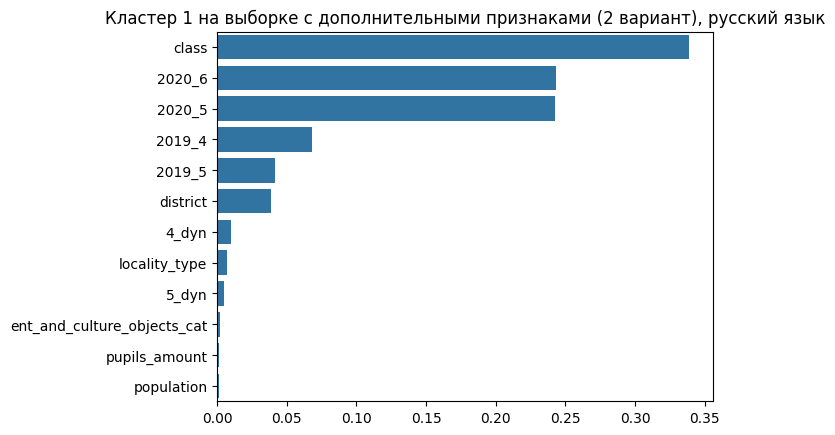

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


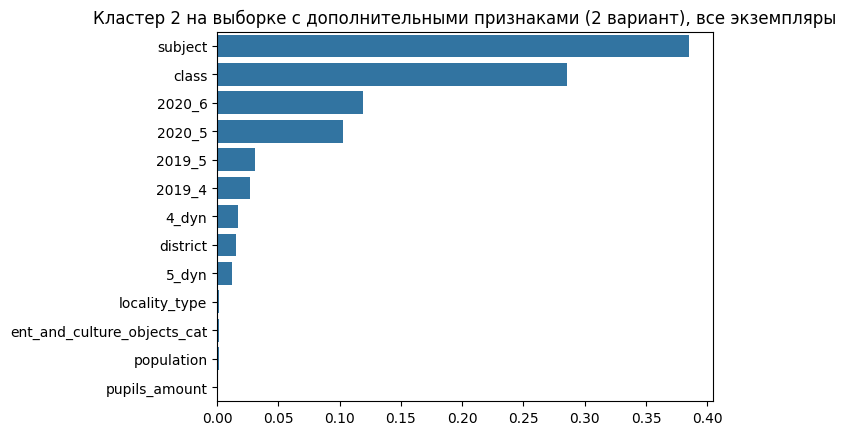

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


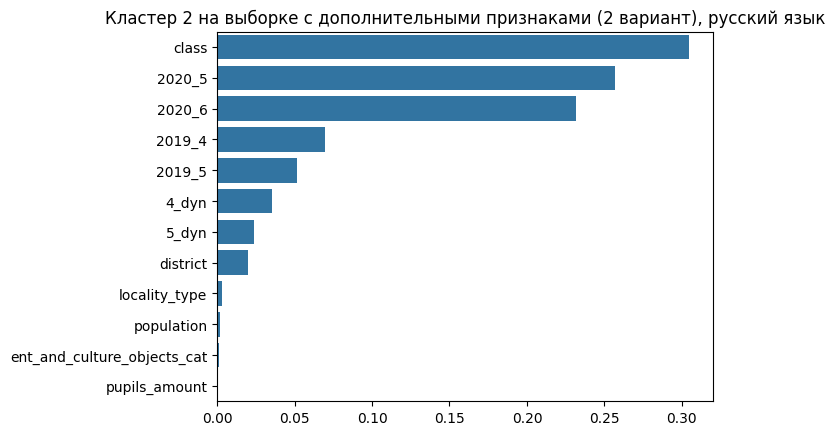

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


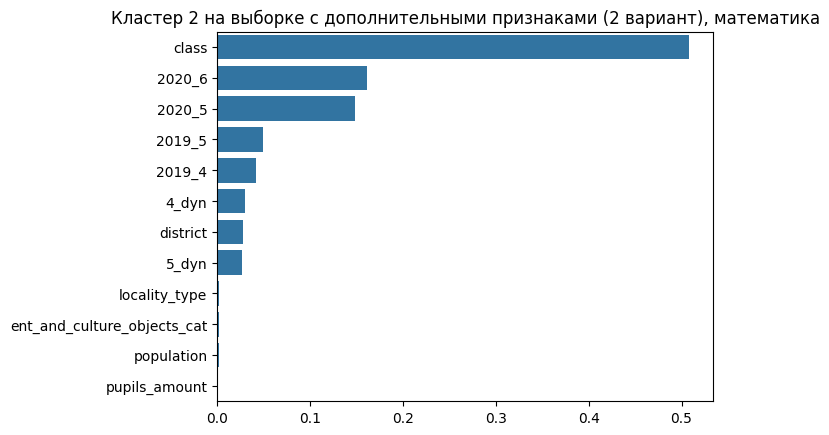

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


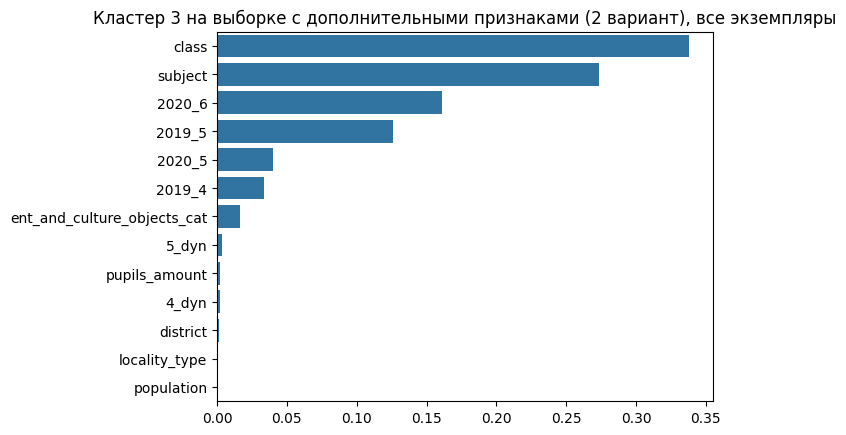

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


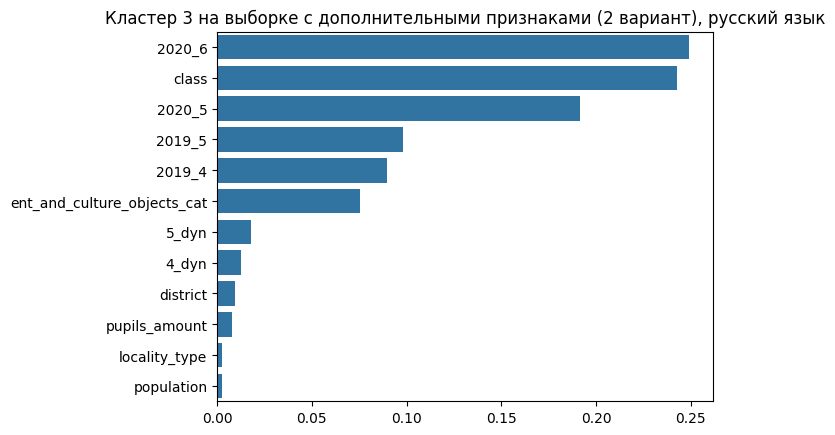

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


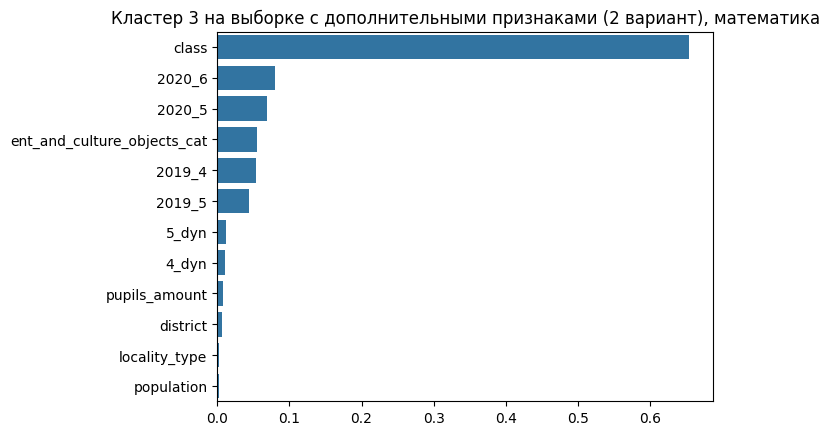

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


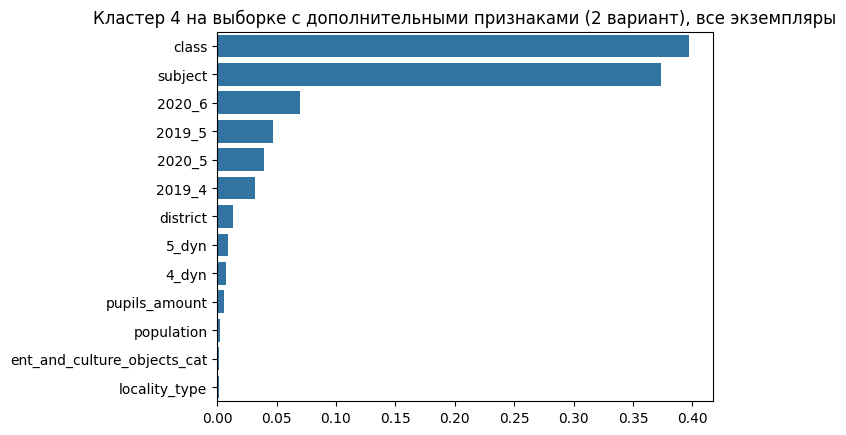

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


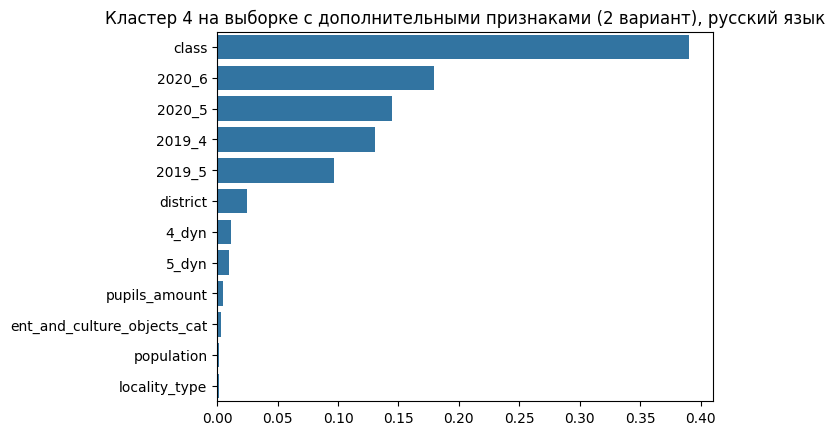

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


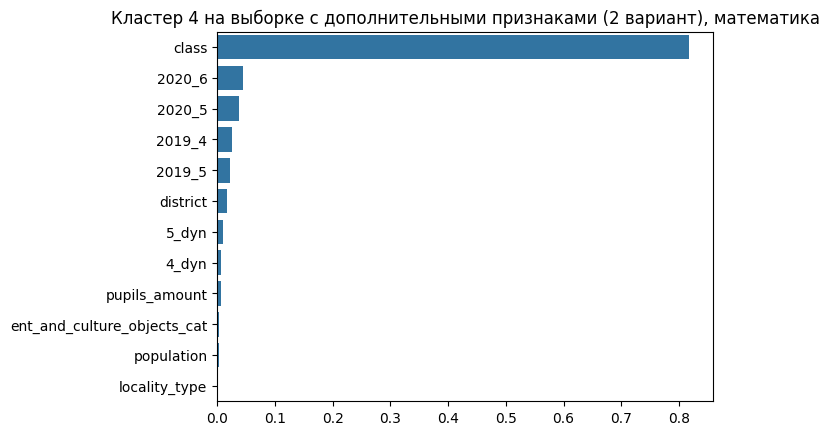

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


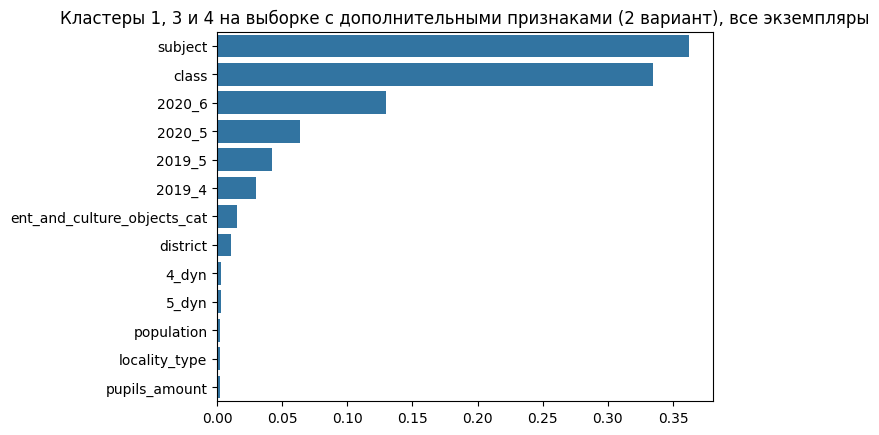

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


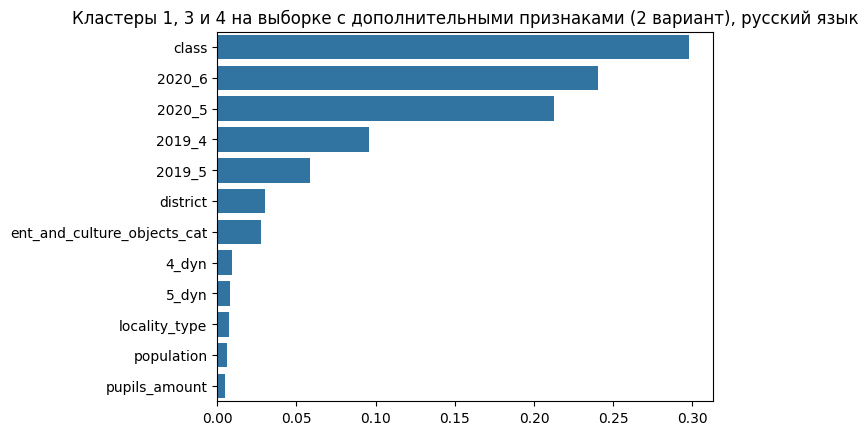

<ipython-input-25-2697b9f9c5a6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set_yticklabels(original_feature_names)


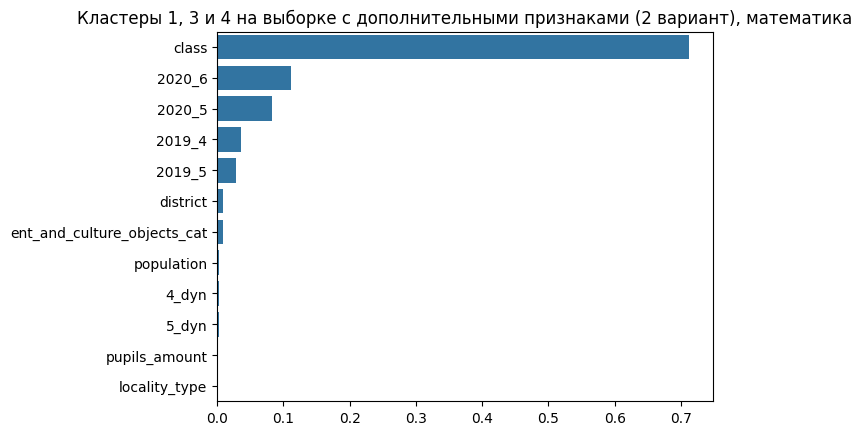

In [ ]:
third_clusters_titles = list(itertools.chain(*[[title + ', все экземпляры', title + ', русский язык', title + ', математика'] for title in list(third_clusters_results.index)]))
plot_feature_importances_on_multiple_models(zip(third_clusters_models, third_clusters_titles))

Как и в предыдущих пунктах, самыми важнымии признаками являются предмет (если используется вся выборка), класс и средние баллы

Для предсказаний по русскому языку, как и по математике, также важными становятся признаки округа и объектов культуры и досуга, а вот количество учеников особой роли не играет

## Предсказания на большой выборке без признаков и анализ получившихся предсказаний

### Подсчёт статистик

Получим предсказания для модели из первого и третьего кластеров из выборки без дополнительных признаков

Для этого сначала нужно выделить кластеры из всей выборки и разделить их по предметам

In [ ]:
def get_cluster(data, clusters, cluster_index, value, data_delimiter='subject', cluster_delimiter='cluster', columns_to_delete=['subject', 'correction']):
    return data[(data.index.str[:11].isin(list(clusters[clusters[cluster_delimiter] == cluster_index].index))) & (data[data_delimiter] == value)].drop(columns=columns_to_delete)

In [ ]:
first_rus_cluster = get_cluster(large_data, begin_clusters, 0, 'rus')
first_math_cluster = get_cluster(large_data, begin_clusters, 0, 'math')
second_rus_cluster = get_cluster(large_data, begin_clusters, 1, 'rus')
second_math_cluster = get_cluster(large_data, begin_clusters, 1, 'math')
third_rus_cluster = get_cluster(large_data, begin_clusters, 2, 'rus')
third_math_cluster = get_cluster(large_data, begin_clusters, 2, 'math')
fourth_rus_cluster = get_cluster(large_data, begin_clusters, 3, 'rus')
fourth_math_cluster = get_cluster(large_data, begin_clusters, 3, 'math')

Теперь сделаем предсказания соответствующими моделями

In [ ]:
first_rus_predictions = first_clusters_models[4].predict(first_rus_cluster.drop(columns='target'))
first_math_predictions = first_clusters_models[5].predict(first_math_cluster.drop(columns='target'))
second_rus_predictions = first_clusters_models[7].predict(second_rus_cluster.drop(columns='target'))
second_math_predictions = first_clusters_models[8].predict(second_math_cluster.drop(columns='target'))
third_rus_predictions = first_clusters_models[10].predict(third_rus_cluster.drop(columns='target'))
third_math_predictions = first_clusters_models[11].predict(third_math_cluster.drop(columns='target'))
fourth_rus_predictions = first_clusters_models[13].predict(fourth_rus_cluster.drop(columns='target'))
fourth_math_predictions = first_clusters_models[14].predict(fourth_math_cluster.drop(columns='target'))

Получим предсказания

In [ ]:
predictions = pd.concat((
    first_rus_cluster.assign(predictions=first_rus_predictions),
    first_math_cluster.assign(predictions=first_math_predictions),
    second_rus_cluster.assign(predictions=second_rus_predictions),
    second_math_cluster.assign(predictions=second_math_predictions),
    third_rus_cluster.assign(predictions=third_rus_predictions),
    third_math_cluster.assign(predictions=third_math_predictions),
    fourth_rus_cluster.assign(predictions=fourth_rus_predictions),
    fourth_math_cluster.assign(predictions=fourth_math_predictions)
)).sample(frac=1)

Далее запишем 2 датасета с признаками - один с признаками, другой без

In [ ]:
predictions.to_csv('predictions_with_features.csv')
predictions[['target', 'predictions']].to_csv('predictions.csv')

Добавим столбцы с предсказаниями в датасеты

In [ ]:
first_rus_cluster['predictions'] = first_rus_predictions
first_math_cluster['predictions'] = first_math_predictions
third_rus_cluster['predictions'] = third_rus_predictions
third_math_cluster['predictions'] = third_math_predictions

Посмотрим на датасеты с предсказаниями

In [ ]:
first_rus_cluster

class    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn        locality_type      population  pupils_amount district    target  predictions
login                                                                                                                                                                   
sch01110024_4_rus      4  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514                 НПСТ  10.000-100.000            896      ЮФО  0.731955     0.710004
sch01110103_4_rus      4  0.705565  0.664648  0.575103  0.484162 -0.130462 -0.180487                Город        100.000+           1158      ЮФО  0.705013     0.668386
sch01110123_4_rus      4  0.766524  0.673130  0.624530  0.871255 -0.141994  0.198125                Город  10.000-100.000            725      ЮФО  0.724342     0.728208
sch01113034_4_rus      4  0.707756  0.592732  0.327935  0.390093 -0.379821 -0.202639                Город        100.000+            375      ЮФО  0.455742     0.547334
sch01113040_4_rus      4  0.667544  0.612348  0.443780  0.252122 -0.223764 -0.360226  Столица субъекта РФ        100.000+            276      ЮФО  0.652433     0.590723
...                  ...       ...       ...       ...       ...       ...       ...                  ...             ...            ...      ...       ...          ...
sch31110056_6_rus      6  0.632624  0.655285  0.548059  0.656156 -0.084565  0.000872  Столица субъекта РФ        100.000+             39      ЦФО  0.793210     0.761766
sch31110079_6_rus      6  0.609485  0.595926  0.458554  0.614916 -0.150931  0.018990                 НПГТ    1.000-10.000            768      ЦФО  0.689157     0.732945
sch31110087_6_rus      6  0.605896  0.679433  0.404535  0.461538 -0.201361 -0.217894                 НПСТ  10.000-100.000            617      ЦФО  0.735043     0.675358
sch31110149_6_rus      6  0.659665  0.719192  0.624806  0.663124 -0.034859 -0.056068                Город  10.000-100.000            557      ЦФО  0.810764     0.774482
sch31110158_6_rus      6  0.675661  0.694444  0.582086  0.705810 -0.093575  0.011366                Город  10.000-100.000           1149      ЦФО  0.819981     0.793810

[2153 rows x 13 columns]

In [ ]:
first_math_cluster

class    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn        locality_type      population  pupils_amount district    target  predictions
login                                                                                                                                                                    
sch01110024_4_math      4  0.590659  0.485795  0.584831  0.504268 -0.005828  0.018473                 НПСТ  10.000-100.000            896      ЮФО  0.660000     0.618070
sch01110103_4_math      4  0.687398  0.514815  0.554945  0.362381 -0.132453 -0.152434                Город        100.000+           1158      ЮФО  0.612385     0.632259
sch01110123_4_math      4  0.683929  0.460169  0.584483  0.678571 -0.099446  0.218402                Город  10.000-100.000            725      ЮФО  0.574176     0.631660
sch01113034_4_math      4  0.533333  0.393182  0.448148  0.316667 -0.085185 -0.076515                Город        100.000+            375      ЮФО  0.470833     0.524149
sch01113040_4_math      4  0.536667  0.452000  0.511364  0.566667 -0.025303  0.114667  Столица субъекта РФ        100.000+            276      ЮФО  0.641509     0.586995
...                   ...       ...       ...       ...       ...       ...       ...                  ...             ...            ...      ...       ...          ...
sch31110056_6_math      6  0.744382  0.593902  0.543333  0.550000 -0.201049 -0.043902  Столица субъекта РФ        100.000+             39      ЦФО  0.544872     0.466953
sch31110079_6_math      6  0.645732  0.603279  0.416406  0.478667 -0.229325 -0.124612                 НПГТ    1.000-10.000            768      ЦФО  0.414458     0.426433
sch31110087_6_math      6  0.670408  0.614286  0.584375  0.500000 -0.086033 -0.114286                 НПСТ  10.000-100.000            617      ЦФО  0.438462     0.440144
sch31110149_6_math      6  0.723973  0.626471  0.626190  0.611538 -0.097782 -0.014932                Город  10.000-100.000            557      ЦФО  0.530769     0.474727
sch31110158_6_math      6  0.737698  0.692233  0.576238  0.688835 -0.161461 -0.003398                Город  10.000-100.000           1149      ЦФО  0.561638     0.503347

[1935 rows x 13 columns]

In [ ]:
third_rus_cluster

class    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn locality_type    population  pupils_amount district    target  predictions
login                                                                                                                                                          
sch01110019_4_rus      4  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705          НПСТ  1.000-10.000            251      ЮФО  0.653110     0.621060
sch01110031_4_rus      4  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540          НПСТ  1.000-10.000            162      ЮФО  0.673375     0.653327
sch01110041_4_rus      4  0.521672  0.654971  0.268879  0.333333 -0.252793 -0.321637          НПСТ  1.000-10.000            219      ЮФО  0.399123     0.536651
sch01110052_4_rus      4  0.633381  0.774955  0.507101  0.608283 -0.126280 -0.166672          НПСТ  1.000-10.000            812      ЮФО  0.700478     0.635049
sch01110079_4_rus      4  0.659280  0.746130  0.585812  0.756966 -0.073467  0.010836          НПСТ  1.000-10.000            174      ЮФО  0.726974     0.663549
...                  ...       ...       ...       ...       ...       ...       ...           ...           ...            ...      ...       ...          ...
sch31110066_6_rus      6  0.637037  0.607588  0.446091  0.536257 -0.190947 -0.071331          НПСТ  1.000-10.000            429      ЦФО  0.753439     0.702133
sch31110143_6_rus      6  0.600000  0.565432  0.482540  0.476768 -0.117460 -0.088664          НПСТ  1.000-10.000             92      ЦФО  0.708889     0.684360
sch31110201_6_rus      6  0.505556  0.716239  0.681481  0.702222  0.175926 -0.014017          НПСТ  1.000-10.000            106      ЦФО  0.798291     0.791066
sch31110208_6_rus      6  0.531944  0.630065  0.419753  0.481944 -0.112191 -0.148121          НПСТ  1.000-10.000            146      ЦФО  0.744444     0.672606
sch31110228_6_rus      6  0.628889  0.522727  0.516667  0.453889 -0.112222 -0.068838          НПСТ  1.000-10.000            405      ЦФО  0.708709     0.651856

[1827 rows x 13 columns]

In [ ]:
third_math_cluster

class    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn locality_type    population  pupils_amount district    target  predictions
login                                                                                                                                                           
sch01110019_4_math      4  0.512069  0.379412  0.500000  0.457692 -0.012069  0.078281          НПСТ  1.000-10.000            251      ЮФО  0.580952     0.550175
sch01110031_4_math      4  0.535000  0.573077  0.472727  0.362500 -0.062273 -0.210577          НПСТ  1.000-10.000            162      ЮФО  0.552778     0.562606
sch01110041_4_math      4  0.538235  0.555769  0.328571  0.238462 -0.209664 -0.317308          НПСТ  1.000-10.000            219      ЮФО  0.475000     0.546875
sch01110052_4_math      4  0.606849  0.539655  0.478169  0.456707 -0.128680 -0.082948          НПСТ  1.000-10.000            812      ЮФО  0.624167     0.575968
sch01110079_4_math      4  0.545000  0.663889  0.504545  0.553125 -0.040455 -0.110764          НПСТ  1.000-10.000            174      ЮФО  0.615625     0.582315
...                   ...       ...       ...       ...       ...       ...       ...           ...           ...            ...      ...       ...          ...
sch30100208_6_math      6  0.586842  0.678571  0.433333  0.376471 -0.153509 -0.302101          НПСТ  1.000-10.000            120      ЮФО  0.346667     0.391548
sch31110016_6_math      6  0.693103  0.546875  0.568750  0.407692 -0.124353 -0.139183          НПСТ  1.000-10.000            169      ЦФО  0.482692     0.393702
sch31110066_6_math      6  0.664773  0.546250  0.451667  0.476923 -0.213106 -0.069327          НПСТ  1.000-10.000            429      ЦФО  0.373810     0.419952
sch31110143_6_math      6  0.635000  0.461111  0.466667  0.665000 -0.168333  0.203889          НПСТ  1.000-10.000             92      ЦФО  0.455556     0.483752
sch31110201_6_math      6  0.495833  0.638462  0.571429  0.465000  0.075595 -0.173462          НПСТ  1.000-10.000            106      ЦФО  0.330000     0.426169

[1705 rows x 13 columns]

Напишем функцию для подсчёта различных функций по кластеру по 4, 5 и 6 классам отдельно

In [ ]:
def calculate_statistics(
    cluster, cluster_number, subject_value, statistics_column, agg_func,
    statistics=pd.DataFrame()
):
    unique_classes = cluster['class'].unique()
    local_clusters = [cluster_number] * len(unique_classes)
    local_subjects = [subject_value] * len(unique_classes)
    local_statistics = []

    for class_value in unique_classes:
        local_cluster = cluster[cluster['class'] == class_value]
        local_statistics.append(agg_func(local_cluster))

    return pd.concat((statistics, pd.DataFrame({
        'cluster': local_clusters,
        'subject': local_subjects,
        'class': unique_classes,
        statistics_column: local_statistics
    })))

Напишем функцию для рассчёта корреляции между истинными значениями успеваемости и предсказаниями

In [ ]:
def correlation(cluster):
    return cluster[['target', 'predictions']].corr().iloc[0]['predictions']

Напишем функцию для рассчёта абсолютной ошибки между истинными значениями успеваемости и предсказаниями

In [ ]:
def absolute_error(cluster, apply_mean=True):
    statistics = abs(cluster['target'] - cluster['predictions'])
    if apply_mean:
        statistics = statistics.mean()
    return statistics

Напишем функцию для рассчёта относительной ошибки между истинными значениями успеваемости и предсказаниями

In [ ]:
def relative_error(cluster, apply_mean=True):
    statistics = (abs(cluster['target'] - cluster['predictions']) / cluster['target'])
    if apply_mean:
        statistics = statistics.mean()
    return statistics

Посчитаем корреляцию между истинными уровня успеваемости и предсказаниями

In [ ]:
correlation_statistics = calculate_statistics(
    first_rus_cluster, 1, 'rus', 'correlation', correlation
)
correlation_statistics = calculate_statistics(
    first_math_cluster, 1, 'math', 'correlation', correlation,
    correlation_statistics
)
correlation_statistics = calculate_statistics(
    third_rus_cluster, 3, 'rus', 'correlation', correlation,
    correlation_statistics
)
correlation_statistics = calculate_statistics(
    third_math_cluster, 3, 'math', 'correlation', correlation,
    correlation_statistics
)

In [ ]:
correlation_statistics = pd.pivot_table(correlation_statistics, values='correlation', index=['cluster', 'subject'], columns=['class'])
correlation_statistics

class                   4         5         6
cluster subject                              
1       math     0.715891  0.683092  0.679012
        rus      0.628772  0.708152  0.705622
3       math     0.570205  0.658197  0.676317
        rus      0.509573  0.651796  0.668072

Видим, что корреляция находится в диапазоне от 0.5 до 0.716, что говорит о достаточно выской корреляции между целевой переменной и предсказаниями

Посчитаем абсолютную ошибку между истинными уровня успеваемости и предсказаниями

In [ ]:
absolute_error_statistics = calculate_statistics(
    first_rus_cluster, 1, 'rus', 'absolute error', absolute_error
)
absolute_error_statistics = calculate_statistics(
    first_math_cluster, 1, 'math', 'absolute error', absolute_error,
    absolute_error_statistics
)
absolute_error_statistics = calculate_statistics(
    third_rus_cluster, 3, 'rus', 'absolute error', absolute_error,
    absolute_error_statistics
)
absolute_error_statistics = calculate_statistics(
    third_math_cluster, 3, 'math', 'absolute error', absolute_error,
    absolute_error_statistics
)

In [ ]:
absolute_error_statistics = pd.pivot_table(absolute_error_statistics, values='absolute error', index=['cluster', 'subject'], columns=['class'])
absolute_error_statistics

class                   4         5         6
cluster subject                              
1       math     0.046216  0.040508  0.035826
        rus      0.046112  0.043838  0.044901
3       math     0.052302  0.044221  0.038977
        rus      0.053720  0.049477  0.048032

Посчитаем относительную ошибку между истинными уровня успеваемости и предсказаниями

In [ ]:
relative_error_statistics = calculate_statistics(
    first_rus_cluster, 1, 'rus', 'relative error', relative_error
)
relative_error_statistics = calculate_statistics(
    first_math_cluster, 1, 'math', 'relative error', relative_error,
    relative_error_statistics
)
relative_error_statistics = calculate_statistics(
    third_rus_cluster, 3, 'rus', 'relative error', relative_error,
    relative_error_statistics
)
relative_error_statistics = calculate_statistics(
    third_math_cluster, 3, 'math', 'relative error', relative_error,
    relative_error_statistics
)

In [ ]:
relative_error_statistics = pd.pivot_table(relative_error_statistics, values='relative error', index=['cluster', 'subject'], columns=['class'])
relative_error_statistics

class                   4         5         6
cluster subject                              
1       math     0.078468  0.085243  0.093095
        rus      0.071323  0.081597  0.068341
3       math     0.093603  0.096833  0.104302
        rus      0.089638  0.092802  0.074571

Теперь посчитаем суммарную среднеквадратичную ошибку между предсказаниями и целевой переменной

In [ ]:
first_rus_mse = mean_squared_error(first_rus_cluster['target'], first_rus_predictions)
first_math_mse = mean_squared_error(first_math_cluster['target'], first_math_predictions)
third_rus_mse = mean_squared_error(third_rus_cluster['target'], third_rus_predictions)
third_math_mse = mean_squared_error(third_math_cluster['target'], third_math_predictions)

Посчитаем финальную ошибку

In [ ]:
final_mse = (first_rus_mse * first_rus_cluster.shape[0] + first_math_mse * first_math_cluster.shape[0] + third_rus_mse * third_rus_cluster.shape[0]
             + third_math_mse * third_math_cluster.shape[0]) / (first_rus_cluster.shape[0] + first_math_cluster.shape[0] + third_rus_cluster.shape[0] + third_math_cluster.shape[0])
final_mse

0.0034819755839809513

То есть среднеквадратичная ошибка на двух самых лучших кластерах составляет порядка 0.0035, что примерно соответствует ошибке на двух лучших кластерах

### Визуализация данных

Далее построим диаграммы рассеяния между предсказаниями и истинными уровнями успеваемости для 4-6 классов для каждого кластера

Также построим наилучшую с точки зрения среднеквадратичной ошибки регрессионную прямую, которой можно было бы предсказывать целевую переменную по предсказаниям

In [ ]:
def plot_scatter(
    cluster, cluster_name, correlations, figsize=(21, 7), delimiter='class',
    x='predictions', y='target', significal_plot=3, significal_error=6,
    significal_correlation=3
):
    unique = cluster[delimiter].unique()
    fig, ax = plt.subplots(figsize=figsize, ncols=unique.shape[0])
    fig.suptitle(cluster_name)
    for index, value in enumerate(unique):
        dataset = cluster[cluster[delimiter] == value]
        ax[index].scatter(dataset[x], dataset[y], color='blue')
        a, b = np.polyfit(dataset[x], dataset[y], 1)
        label = f'y≈'
        rounded_a = round(a, significal_plot)
        if (abs(rounded_a) != 1):
            label += f'{rounded_a} * x'
        if b > 0:
            label += f' + {round(b, significal_plot)}'
        elif b < 0:
            label += f' - {round(abs(b), significal_plot)}'
        label += f',\nerror: {("{:." + f"{significal_error}" + "f}").format(mean_squared_error(dataset[y], a * dataset[x] + b))}'
        label += f',\ncorrelation: {("{:." + f"{significal_correlation}" + "f}").format(correlations[index])}'
        ax[index].plot(dataset[x], a * dataset[x] + b, color='red', label=label)
        ax[index].set_title(f'{value} {delimiter}')
        ax[index].set_xlabel(x)
        ax[index].set_ylabel(y)
        ax[index].grid()
        ax[index].legend()
    plt.show()

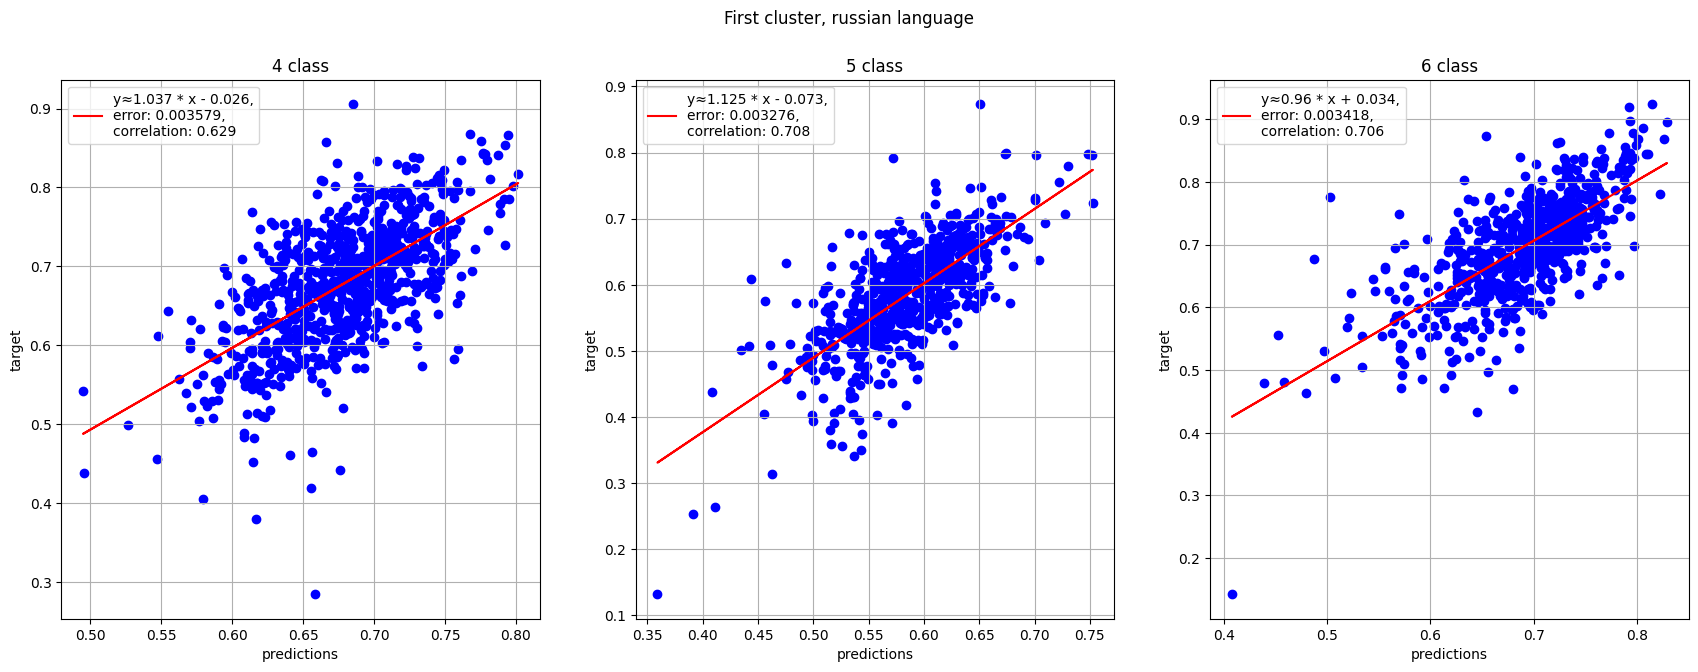

In [ ]:
plot_scatter(first_rus_cluster, 'First cluster, russian language', correlation_statistics.iloc[1].values)

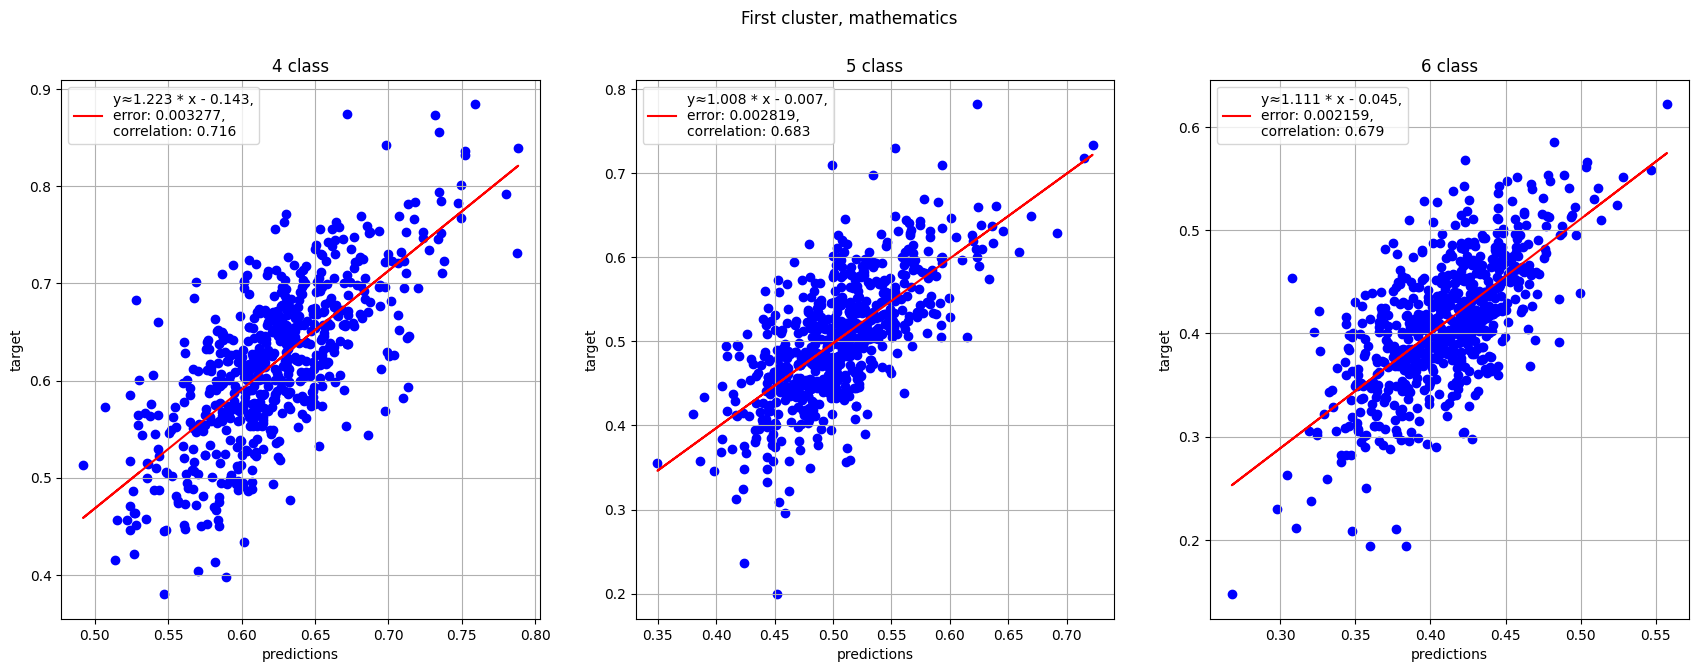

In [ ]:
plot_scatter(first_math_cluster, 'First cluster, mathematics', correlation_statistics.iloc[0].values)

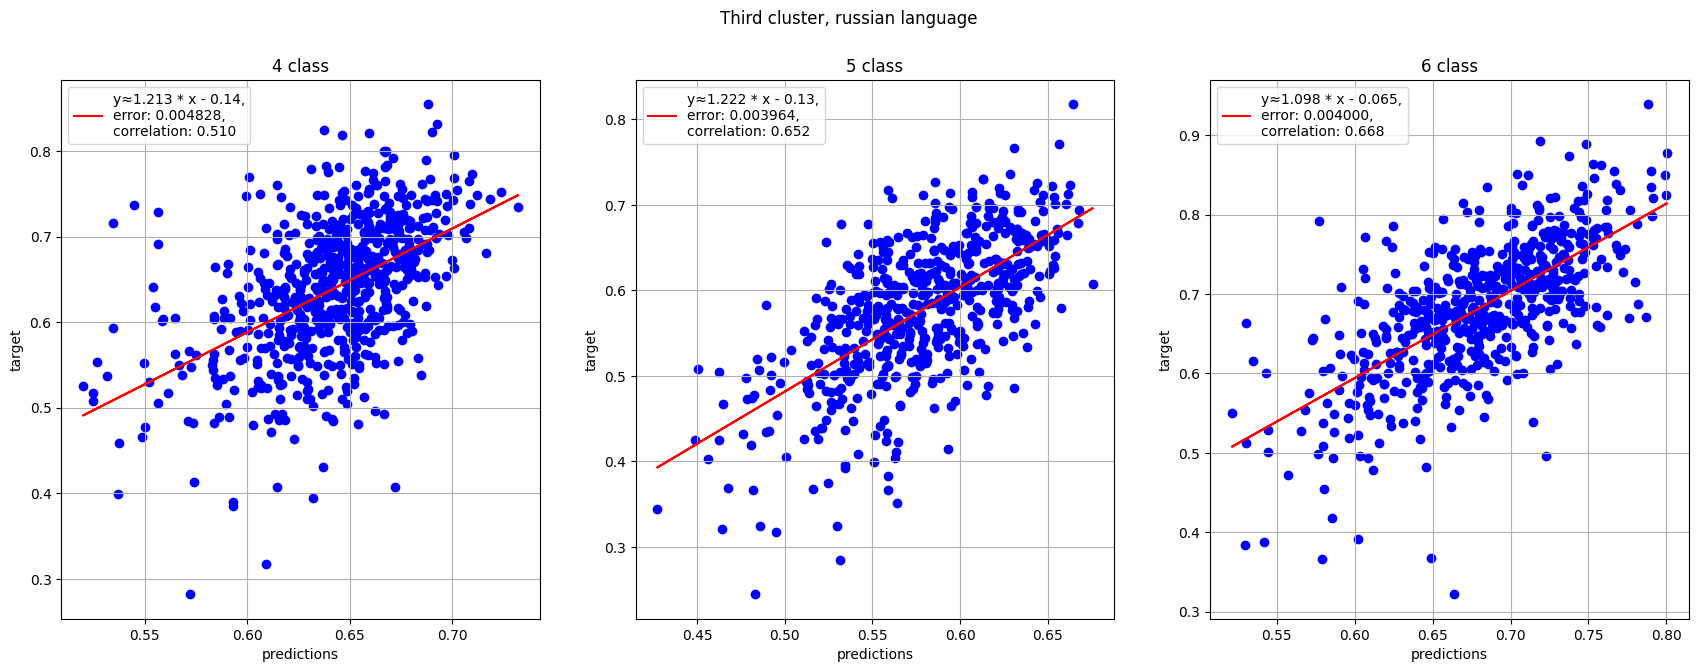

In [ ]:
plot_scatter(third_rus_cluster, 'Third cluster, russian language', correlation_statistics.iloc[3].values)

In [ ]:
plot_scatter(third_math_cluster, 'Third cluster, mathematics', correlation_statistics.iloc[2].values)

Теперь будем визуализировать распределение абсолютных и относительных ошибок

In [ ]:
def plot_errors(
    pairs, graphics_title, func, x_title, figsize=(21, 7), delimiter='class',
    quantile=0.5
):
    colors = ['blue', 'orange', 'green']
    fig, ax = plt.subplots(figsize=figsize, ncols=len(pairs))
    fig.suptitle(graphics_title)
    for pair_index, pair in enumerate(pairs):
        cluster = pair[0]
        unique = cluster[delimiter].unique()
        for color_index, value in enumerate(unique):
            dataset = cluster[cluster[delimiter] == value]
            error = func(dataset, apply_mean=False)
            local_label = f'{value} {delimiter}'
            sns.kdeplot(error, ax=ax[pair_index], cut=0, fill=True, color=colors[color_index], label=local_label + ', density')
            quantile_value = np.quantile(error, quantile)
            ax[pair_index].axvline(x=quantile_value, color=colors[color_index], label=local_label + f', quantile={quantile}')
        ax[pair_index].set_title(pair[1])
        ax[pair_index].set_xlabel(x_title)
        ax[pair_index].legend()
        ax[pair_index].grid()
    plt.show()

Составим вспомогательный кластер из пар, состоящих из кластеров и их названий

При этом в одном списке содержатся кластеры по различным предметам, соответствующие какому-то конкретному кластеру, полученному на выборке без дополнительных признаков

In [ ]:
first_clusters_pairs = [(first_rus_cluster, 'Russian language'), (first_math_cluster, 'Mathematics')]
third_clusters_pairs = [(third_rus_cluster, 'Russian language'), (third_math_cluster, 'Mathematics')]

Посчитаем абсолютные ошибки на первом и третьем кластере

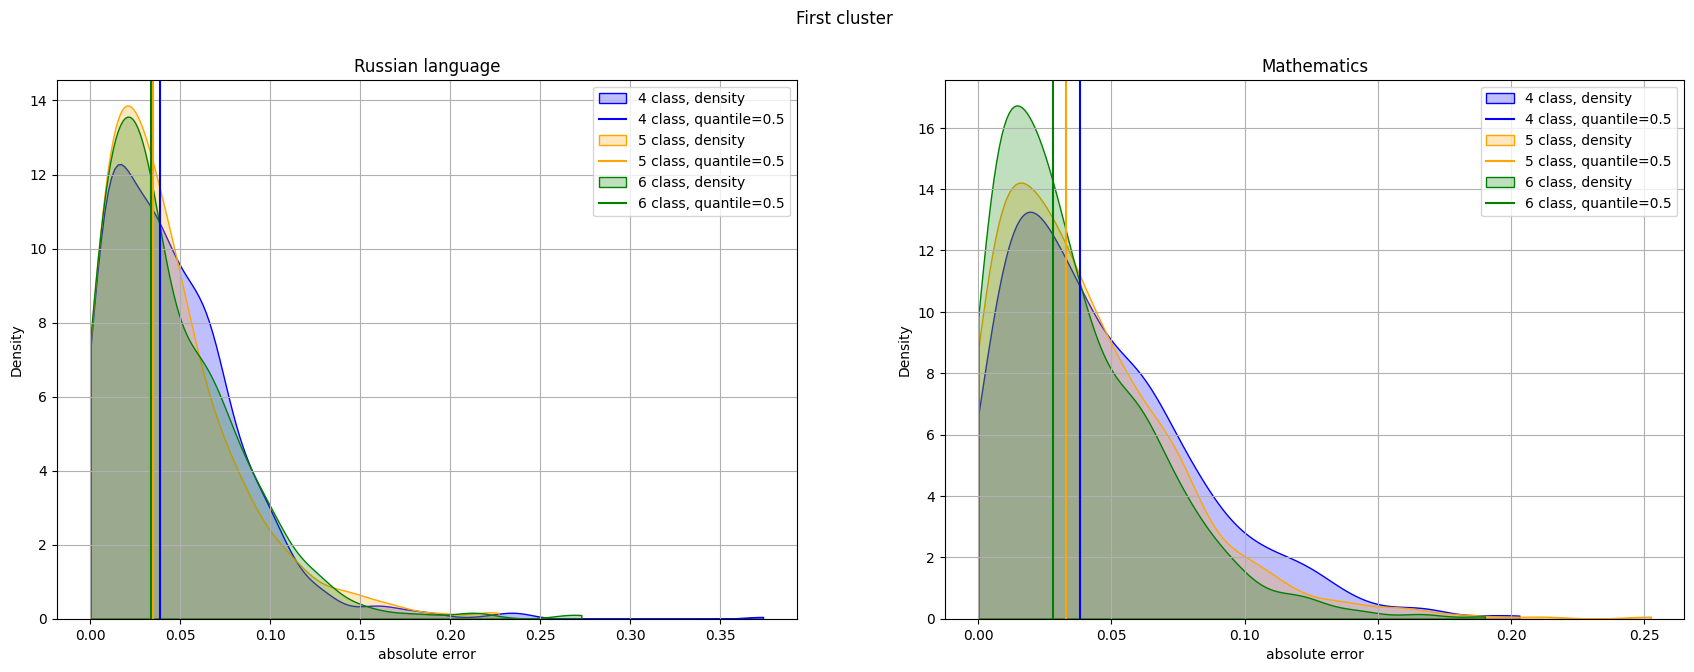

In [ ]:
plot_errors(first_clusters_pairs, 'First cluster', absolute_error, 'absolute error')

In [ ]:
plot_errors(third_clusters_pairs, 'Third cluster', absolute_error, 'absolute error')

Видим, что 50-ые процентили меньше 0.05, дальше с ростом значения абсолютная ошибки падает, поэтому можно сделать вывод, что более половины всех ошибок имеют значения меньше 0.05

Посчитаем относительные ошибки на первом и третьем кластере

In [ ]:
plot_errors(first_clusters_pairs, 'First cluster', relative_error, 'relative error')

In [ ]:
plot_errors(third_clusters_pairs, 'Third cluster', relative_error, 'relative error')

Здесь ситуация, подобная той, что была с абсолютной ошибкой (квантили также находятся в райне 0.05), однако сами значения теперь могут принимать значения, большие 1 и некоторые находятся даже в районе 2 (как например "математические" выборки в третьем кластере), что означает, что есть предсказание, по модулю отличающееся от реального значения почти в 5 раз. Благо таких значений мало